In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json

from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.metrics import *
import time
from datetime import datetime
import os
from torch.utils import data
import random
import copy
import itertools
import io
import uuid
from sklearn.model_selection import KFold, train_test_split

import warnings
warnings.filterwarnings('ignore')

import wandb
wandb_username = 'denizjafari'
local_username = 'denizjafari'


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0') 
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [3]:
# source: https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
#example-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm,fold, classnames, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classnames))
    plt.xticks(tick_marks, classnames, rotation=45)
    plt.yticks(tick_marks, classnames)
    
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=19)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('ViewNetConfMtrx' + fold + '.png')
    wandb.log({"confusion"+ fold: plt})

In [4]:
# root directory
root_dir = "/home/andreasabo/Documents/HNProject/"
split_file_base = "/home/andreasabo/Documents/HNUltra/"

# data directory on current machine: abhishekmoturu, andreasabo, denizjafari, navidkorhani
data_dir = "/home/" + local_username + "/Documents/HNProject/all_label_img/"

# read target df
csv_path = os.path.join(root_dir, "all_splits_1000000.csv")
data_df = pd.read_csv(csv_path, usecols=['subj_id', 'image_ids', 'view_label', 'view_train'])

# Are we doing the final test?
test_data = False

### **Reading Data Indicies and Labels**

In [5]:
label_mapping = {'Other':0, 'Saggital_Right':1, 'Transverse_Right':2, 
                 'Saggital_Left':3, 'Transverse_Left':4, 'Bladder':5}
label_unmapping = {0: 'Other', 1:'Saggital_Right', 2: 'Transverse_Right', 
                   3:'Saggital_Left', 4:'Transverse_Left', 5: 'Bladder'}

data_df['view_label'] = data_df['view_label'].map(label_mapping)

train_df = data_df[data_df.view_train == 1]
test_df = data_df[data_df.view_train == 0]

unique_subj = train_df.subj_id.unique()

# Create the splits for 5-fold cross validation based on subj_id
data_split_file = split_file_base + 'data_splits.json'
if not os.path.isfile(data_split_file):

    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    fold = 0
    all_folds = {}
    for train_subj, val_subj in kf.split(unique_subj):
        train_ids  = unique_subj[train_subj]
        val_ids = unique_subj[val_subj]

        train_images = train_df[train_df.subj_id.isin(train_ids)].image_ids.tolist()
        val_images = train_df[train_df.subj_id.isin(val_ids)].image_ids.tolist()
        train_labels = train_df[train_df.subj_id.isin(train_ids)].view_label.tolist()
        val_labels = train_df[train_df.subj_id.isin(val_ids)].view_label.tolist()
        cur_fold = {'train_ids': train_images, 'valid_ids': val_images, 'train_labels': train_labels, 'valid_labels': val_labels}
        all_folds[fold] = cur_fold
        fold += 1

    print("Saving data splits")
    with open(data_split_file, 'w') as f:
        json.dump(all_folds, f)
        
else: # just load from file
    print("Reading splits from file")
    with open(data_split_file, 'r') as f:
        all_folds = json.load(f)

# If we're testing, overwrite the training data with the entire train/test data
#if test_data:
#    train_images = train_df.image_ids.tolist()
test_images = test_df.image_ids.tolist()
#    train_labels = train_df.view_label.tolist()
test_labels = test_df.view_label.tolist()

test_set = {'test_ids': test_images, 'test_labels': test_labels}
    
#all_folds['test'] = cur_fold

Reading splits from file


In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name == 'viewnet':
        conv1_filters = 8
        conv2_filters = 16
        conv3_filters = 32
        linear1_size = 512
        dropout = 0.25
        model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
        input_size = 256
        
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


class ViewNet(nn.Module):

    def __init__(self, num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout):
        super(ViewNet, self).__init__()
        self.conv1_filters = conv1_filters
        self.conv2_filters = conv2_filters
        self.conv3_filters = conv3_filters
        self.linear1_size = linear1_size
        self.drop_percent = dropout
        self.max_pool = 4
        self.conv_output = int(self.conv3_filters*(256/(self.max_pool**3))*(256/(self.max_pool**3)))
        print("conv_output: ", self.conv_output)

        
        self.conv1 = nn.Conv2d(1, self.conv1_filters, 4, padding=2)
        self.conv2 = nn.Conv2d(self.conv1_filters, self.conv2_filters, 4, padding=2)
        self.conv3 = nn.Conv2d(self.conv2_filters, self.conv3_filters, 4, padding=2)
        self.pool = nn.MaxPool2d(self.max_pool, self.max_pool)
        self.dropout = nn.Dropout(self.drop_percent)
        self.linear1 = nn.Linear(self.conv_output, self.linear1_size)
        self.linear2 = nn.Linear(self.linear1_size, num_classes)
    
    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.conv1(x))))
        x = self.pool(self.dropout(F.relu(self.conv2(x))))
        x = self.pool(self.dropout(F.relu(self.conv3(x))))
        x = x.view(-1, self.conv_output) 
        x = self.dropout(F.relu((self.linear1(x))))
        x = self.linear2(x)
        return x

In [8]:
# Code from: https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=True):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, final_testing=False):
    es = EarlyStopping(patience = 15)
    stop_now = 0

    since = time.time()
    classnames = ['Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder']
    val_acc_history = []
    
    val_metrics_list = []
    train_metrics_list = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_with_best_val_acc = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 54)

        if stop_now:
            break
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            running_preds = []
            running_labels = []

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                labels = labels.type(torch.long)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        labels = torch.argmax(labels, 1)
                        running_preds += torch.argmax(outputs, 1).tolist()
                        running_labels += labels.tolist()
                        loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} loss:\t{:.4f} | {} acc:\t{:.4f}\n'.format(phase, epoch_loss, phase, epoch_acc))

            if phase == 'train':
                wandb.log({'epoch': epoch, 'train_acc':epoch_acc, 'train_loss':epoch_loss})
                
                cur_train_metrics = {}
                                # compute and log f1, precision, recall for each class
                for c in range(6):
                    running_labels = np.asarray(running_labels)
                    running_preds = np.asarray(running_preds)

                    cur_c_labs_bin = np.asarray([0] *len(running_labels))
                    cur_c_preds_bin = np.asarray([0] *len(running_labels))

                    # Need to binarize
                    cur_c_preds_bin[running_preds == c] = 1
                    cur_c_labs_bin[running_labels == c] = 1
                    f1 = f1_score(cur_c_labs_bin, cur_c_preds_bin)
                    precision = precision_score(cur_c_labs_bin, cur_c_preds_bin)
                    recall = recall_score(cur_c_labs_bin, cur_c_preds_bin)
                    
                    cur_train_metrics['train_' + label_unmapping[c] + '_f1'] = f1
                    cur_train_metrics['train_' + label_unmapping[c] + '_precision'] = precision
                    cur_train_metrics['train_' + label_unmapping[c] + '_recall'] = recall
                    
                
                train_metrics_list.append(cur_train_metrics)
                
                average_types = ['macro', 'micro', 'weighted']
                average_metrics_to_log = ['precision', 'recall', 'f1score', 'support']
                average_dict = {'epoch': epoch}
                for av in average_types:
                    results_tuple = precision_recall_fscore_support(running_labels, running_preds, average=av)
                    for m in range(len(average_metrics_to_log)):      
                        average_dict[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                        cur_train_metrics[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                cur_train_metrics[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)                  
                average_dict[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)     
                wandb.log(cur_train_metrics)
                
            if phase == 'val':
                wandb.log({'valid_loss':epoch_loss, 'valid_acc':epoch_acc, 'epoch': epoch})
               
            
                cur_val_metrics = {}
                # compute and log f1, precision, recall for each class
                for c in range(6):
                    running_labels = np.asarray(running_labels)
                    running_preds = np.asarray(running_preds)

                    cur_c_labs_bin = np.asarray([0] *len(running_labels))
                    cur_c_preds_bin = np.asarray([0] *len(running_labels))

                    # Need to binarize
                    cur_c_preds_bin[running_preds == c] = 1
                    cur_c_labs_bin[running_labels == c] = 1
                    f1 = f1_score(cur_c_labs_bin, cur_c_preds_bin)
                    precision = precision_score(cur_c_labs_bin, cur_c_preds_bin)
                    recall = recall_score(cur_c_labs_bin, cur_c_preds_bin)
                    wandb.log({'valid_' + label_unmapping[c] + '_f1': f1})
                    wandb.log({'valid_' + label_unmapping[c] + '_precision': precision})
                    wandb.log({'valid_' + label_unmapping[c] + '_recall': recall})
                
                    cur_val_metrics['val_' + label_unmapping[c] + '_f1'] = f1
                    cur_val_metrics['val_' + label_unmapping[c] + '_precision'] = precision
                    cur_val_metrics['val_' + label_unmapping[c] + '_recall'] = recall
                
                average_types = ['macro', 'micro', 'weighted']
                average_metrics_to_log = ['precision', 'recall', 'f1score']
                average_dict = {'epoch': epoch}
                for av in average_types:
                    results_tuple = precision_recall_fscore_support(running_labels, running_preds, average=av)
                    for m in range(len(average_metrics_to_log)):      
                        average_dict[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                        cur_val_metrics[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                cur_val_metrics[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)                  
                average_dict[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)     
                print(cur_val_metrics)
                wandb.log(cur_val_metrics)
                
                
                val_metrics_list.append(cur_val_metrics)
                
            if phase == 'train':
                print(classification_report(running_labels, running_preds))
                train_acc = epoch_acc
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_acc_train = train_acc
                epoch_with_best_val_acc = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), os.path.join(wandb.run.dir, "model.pt"))
                print(classification_report(running_labels, running_preds))

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                if es.step(epoch_loss) and not final_testing:
                    stop_now = 1
                    print("EARLY STOPPING " + str(epoch))
                    break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}\n'.format(best_acc))
    
    # Directly save the best results in this fold
    wandb.config.best_acc = best_acc
    wandb.config.best_epoch = epoch_with_best_val_acc

    wandb.config.val_acc_history = val_acc_history
    wandb.config.best_epoch = epoch_with_best_val_acc
    
    wandb.config.update(val_metrics_list[epoch_with_best_val_acc])
    wandb.config.update(train_metrics_list[epoch_with_best_val_acc])
    
    metrics_from_best_epoch = {'best_epoch': epoch_with_best_val_acc, 'last_epoch': epoch}
    metrics_from_best_epoch.update( val_metrics_list[epoch_with_best_val_acc] )
    metrics_from_best_epoch.update( train_metrics_list[epoch_with_best_val_acc] )
    metrics_from_best_epoch.update( {'val_acc': best_acc.data.cpu(), 'train_acc': best_acc_train.data.cpu()} )    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, metrics_from_best_epoch

In [10]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels, transformations=None):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.transformations = transformations
        
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        img_path = data_dir + ID + '.jpg'
        image = Image.open(img_path).convert('L')
        
        if self.transformations:
            image = self.transformations(image)
        
        image = ToTensor()(image)
        
        y = torch.FloatTensor([0]*6)        
        y[int(self.labels[index])] = 1

        return image, y, ID

In [11]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, viewnet]
model_name = "viewnet"

# Number of classes in the dataset: right_sag, right_trav, left_sag, left_trav, bladder, other
num_classes = 6

# Batch size for training (change depending on how much memory you have)
batch_size = 100

# Number of epochs to train for
num_epochs = 100

# Flag for feature extracting. When False, we finetune the whole model; when True we only update the reshaped layer params
feature_extract = False

# Flag for whether or not to use pretrained model
pretrain = False

In [12]:
def train5fold(network_configs, model_ft, lr, wd, amsgrad, i):
    #folds = ['test']
    folds = ['0', '1', '2', '3', '4']
    classnames = ['Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder']
    project_name = 'hnultra_test_apr6_vae'
    random_str = str(uuid.uuid4()).split("-")[0]
    best_metrics_per_fold = []
    test_metrics_per_fold = []
    model_base = copy.deepcopy(model_ft)
    final_df = pd.DataFrame()
    for fold in folds:

        now = datetime.now()
        date_time = now.strftime("%d-%m-%Y.%H:%M:%S")
        wandb.init(project=project_name, entity=wandb_username, name=local_username + '_fold_' + fold, group=random_str)
        partition = all_folds[fold]

        model_ft = copy.deepcopy(model_base)
        model_ft = model_ft.to(device)
        wandb.watch(model_ft)

        # Gather the parameters to be optimized/updated in this run. If we are
        #  finetuning we will be updating all parameters. However, if we are
        #  doing feature extract method, we will only update the parameters
        #  that we have just initialized, i.e. the parameters with requires_grad
        #  is True.
        params_to_update = model_ft.parameters()
        #print("Params to learn:")
        if feature_extract:
            params_to_update = []
            for name,param in model_ft.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    print("\t",name)
        else:
            for name,param in model_ft.named_parameters():
                if param.requires_grad == True:
                    print("\t",name)

        # Observe that all parameters are being optimized
        optimizer_ft = optim.Adam(params_to_update, lr=lr, weight_decay=wd, amsgrad=amsgrad)

        # Setup the loss fxn
        criterion = nn.CrossEntropyLoss()

        shuffle = True
        num_workers = 0
        params = {'batch_size': batch_size,
                  'shuffle': shuffle,
                  'num_workers': num_workers}

        config_dict = {'i': i, 'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': num_workers, 'fold': fold,
                       'lr': lr, 'wd': wd, 'amsgrad': amsgrad, 'model_name': model_name, 'num_classes': num_classes, 
                       'num_epochs': num_epochs, 'feature_extract': feature_extract, "pretrain": pretrain }

        wandb.config.update(config_dict)
        wandb.config.update(network_configs)
        # Tranforms
        trans = transforms.Compose([transforms.RandomAffine(degrees=8, translate=(0.1, 0.1), scale=(0.95,1.25))])

        # Generators
        training_set = Dataset(partition['train_ids'], partition['train_labels'], transformations=trans)
        training_generator = data.DataLoader(training_set, **params)

        validation_set = Dataset(partition['valid_ids'], partition['valid_labels'])
        validation_generator = data.DataLoader(validation_set, **params)
        
        testing_set = Dataset(test_set['test_ids'], test_set['test_labels'])
        test_generator = data.DataLoader(testing_set, **params)

        dataloaders_dict = {'train':training_generator, 'val':validation_generator}

        # Train & Evaluate
        model_ft, hist, metrics_from_best_epoch = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs, is_inception=(model_name=="inception"))
        best_metrics_per_fold.append(metrics_from_best_epoch)
        
        # Test the model on test data
        # saving the results in df for further analysis on machine and year
        
        run_y = []
        run_pred = []
        run_ids = []
        running_loss =  0
        running_corrects = 0
        
        model_ft.eval()
        for inputs, labels, ids in test_generator:
            
            run_ids += np.array(ids).tolist()
            
            labels = labels.type(torch.long)
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # zero the parameter gradients
            optimizer_ft.zero_grad()
            outputs = model_ft(inputs)
            labels = torch.argmax(labels, 1)
            run_pred += torch.argmax(outputs, 1).tolist()
            run_y += labels.tolist()
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        test_loss = running_loss / len(test_generator)
        test_acc = running_corrects.double() / len(test_generator)
        
        
        print('Test loss:\t{:.4f} | Test acc:\t{:.4f}\n'.format( test_loss, test_acc))
        wandb.log({'test_loss':test_loss, 'test_acc':test_acc})
        
        # calculating the metrics
        test_metrics = {'fold': fold}
        # compute and log f1, precision, recall for each class
        for c in range(6):
            run_ids = np.asarray(run_ids)
            run_y = np.asarray(run_y)
            run_pred = np.asarray(run_pred)
            conf_mx = confusion_matrix(run_y, run_pred)
            cur_c_labs_bin = np.asarray([0] *len(run_y))
            cur_c_preds_bin = np.asarray([0] *len(run_y))

            # Need to binarize
            cur_c_preds_bin[run_pred == c] = 1
            cur_c_labs_bin[run_y == c] = 1
            f1 = f1_score(cur_c_labs_bin, cur_c_preds_bin)
            precision = precision_score(cur_c_labs_bin, cur_c_preds_bin)
            recall = recall_score(cur_c_labs_bin, cur_c_preds_bin)

            test_metrics['test_' + label_unmapping[c] + '_f1'] = f1
            test_metrics['test_' + label_unmapping[c] + '_precision'] = precision
            test_metrics['test_' + label_unmapping[c] + '_recall'] = recall
            
            wandb.log({'test_' + label_unmapping[c] + '_f1': f1})
            wandb.log({'test_' + label_unmapping[c] + '_precision': precision})
            wandb.log({'test_' + label_unmapping[c] + '_recall': recall})

        
        plot_confusion_matrix(conf_mx,fold,classnames, title='Test Data Confusion matrix - ViewNet', 
                                      cmap=plt.cm.Blues)
        
        average_types = ['macro', 'micro', 'weighted']
        average_metrics_to_log = ['precision', 'recall', 'f1score', 'support']
        average_dict = {'fold': fold}
        for av in average_types:
            results_tuple = precision_recall_fscore_support(run_y, run_pred, average=av)
            for m in range(len(average_metrics_to_log)):      
                #average_dict[ 'test_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                test_metrics['test_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
        test_metrics['test_acc_average'] = accuracy_score(run_y, run_pred)                  
        #average_dict[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)     
        #wandb.log(test_metrics)
        wandb.config.update(test_metrics)

        
        # saving results in df
        final_df['IDs_iter_' + str(fold)] = np.array(run_ids)
        final_df['labels_iter_' + str(fold)] = np.array(run_y)
        final_df['preds_iter_' + str(fold)] = np.array(run_pred)
        
        test_metrics_per_fold.append(test_metrics)
        
                

    # Calculate the performance metrics on the best model in each fold
    wandb.init(project=project_name, entity=wandb_username, name=local_username + '_ALL', group=random_str)
    config_dict['fold'] = -1
#     wandb.config.update(config_dict)
#     wandb.config.update(network_configs)
    final_df.to_csv (r'final_viewnet_data.csv', index = False, header=True)

    metrics_all = {}
    for fold in best_metrics_per_fold:
        for key in fold:
            if key not in metrics_all:
                metrics_all[key] = [fold[key]]
            else:
                metrics_all[key].append(fold[key]) 
                
    # add test data to metrics_all
    for fold in test_metrics_per_fold:
        for key in fold:
            if key not in metrics_all:
                metrics_all[key] = [fold[key]]
            else:
                metrics_all[key].append(fold[key]) 

    metrics_to_log = {}
    for m in metrics_all:
        try:
            
            metric_list = np.asarray(metrics_all[m])
    #         print(m)
    #         print(metric_list)
    #         print(type(metric_list))
            metrics_to_log[m + '_mean'] = metric_list.mean()    
            metrics_to_log[m + '_stdev'] = metric_list.std()
        except: 
            pass
    wandb.config.update(metrics_to_log)
    return final_df
  

conv_output:  512


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 linear1.weight
	 linear1.bias
	 linear2.weight
	 linear2.bias
Epoch 1/100
------------------------------------------------------
train loss:	1.5739 | train acc:	0.3803

              precision    recall  f1-score   support

           0       0.38      0.89      0.53      3724
           1       0.40      0.09      0.15      1813
           2       0.04      0.00      0.00      1218
           3       0.34      0.22      0.27      1895
           4       0.27      0.01      0.02      1359
           5       0.58      0.27      0.37      1072

    accuracy                           0.38     11081
   macro avg       0.33      0.25      0.22     11081
weighted avg       0.34      0.38      0.29     11081

val loss:	1.5754 | val acc:	0.4188

{'val_Other_f1': 0.5181228538725677, 'val_Other_precision': 0.4843081312410842, 'val_Other_recall': 0.55701394585726, 'val_Saggital_Right_f1': 0.3909774436090226, 'va

train loss:	1.2550 | train acc:	0.5128

              precision    recall  f1-score   support

           0       0.52      0.74      0.61      3724
           1       0.49      0.36      0.41      1813
           2       0.45      0.15      0.22      1218
           3       0.45      0.49      0.47      1895
           4       0.46      0.30      0.36      1359
           5       0.70      0.73      0.72      1072

    accuracy                           0.51     11081
   macro avg       0.51      0.46      0.46     11081
weighted avg       0.50      0.51      0.49     11081

val loss:	1.4925 | val acc:	0.4143

{'val_Other_f1': 0.3948973932334997, 'val_Other_precision': 0.6095890410958904, 'val_Other_recall': 0.29204265791632483, 'val_Saggital_Right_f1': 0.4739429695181907, 'val_Saggital_Right_precision': 0.39834710743801655, 'val_Saggital_Right_recall': 0.5849514563106796, 'val_Transverse_Right_f1': 0.3208191126279863, 'val_Transverse_Right_precision': 0.35471698113207545, 'val_Transv

val loss:	1.3875 | val acc:	0.4974

{'val_Other_f1': 0.503690036900369, 'val_Other_precision': 0.5753424657534246, 'val_Other_recall': 0.4479081214109926, 'val_Saggital_Right_f1': 0.5953002610966057, 'val_Saggital_Right_precision': 0.6440677966101694, 'val_Saggital_Right_recall': 0.5533980582524272, 'val_Transverse_Right_f1': 0.4166666666666667, 'val_Transverse_Right_precision': 0.5737704918032787, 'val_Transverse_Right_recall': 0.32710280373831774, 'val_Saggital_Left_f1': 0.46424870466321244, 'val_Saggital_Left_precision': 0.3888888888888889, 'val_Saggital_Left_recall': 0.5758354755784062, 'val_Transverse_Left_f1': 0.3643122676579926, 'val_Transverse_Left_precision': 0.29577464788732394, 'val_Transverse_Left_recall': 0.47419354838709676, 'val_Bladder_f1': 0.6654411764705883, 'val_Bladder_precision': 0.5691823899371069, 'val_Bladder_recall': 0.8008849557522124, 'val_precision_average_macro': 0.5078377801466988, 'val_recall_average_macro': 0.5298871605199088, 'val_f1score_average_macro'

val loss:	1.3156 | val acc:	0.5228

{'val_Other_f1': 0.5728155339805824, 'val_Other_precision': 0.5650438946528332, 'val_Other_recall': 0.5808039376538146, 'val_Saggital_Right_f1': 0.509090909090909, 'val_Saggital_Right_precision': 0.7979274611398963, 'val_Saggital_Right_recall': 0.3737864077669903, 'val_Transverse_Right_f1': 0.40881763527054105, 'val_Transverse_Right_precision': 0.5730337078651685, 'val_Transverse_Right_recall': 0.3177570093457944, 'val_Saggital_Left_f1': 0.4722792607802874, 'val_Saggital_Left_precision': 0.39316239316239315, 'val_Saggital_Left_recall': 0.5912596401028277, 'val_Transverse_Left_f1': 0.38170347003154576, 'val_Transverse_Left_precision': 0.3734567901234568, 'val_Transverse_Left_recall': 0.3903225806451613, 'val_Bladder_f1': 0.6631578947368421, 'val_Bladder_precision': 0.5494186046511628, 'val_Bladder_recall': 0.8362831858407079, 'val_precision_average_macro': 0.5420071419324851, 'val_recall_average_macro': 0.5150354602258828, 'val_f1score_average_macro':

train loss:	1.0530 | train acc:	0.5971

              precision    recall  f1-score   support

           0       0.59      0.74      0.66      3724
           1       0.63      0.47      0.54      1813
           2       0.57      0.36      0.44      1218
           3       0.52      0.58      0.55      1895
           4       0.54      0.46      0.50      1359
           5       0.77      0.80      0.79      1072

    accuracy                           0.60     11081
   macro avg       0.61      0.57      0.58     11081
weighted avg       0.60      0.60      0.59     11081

val loss:	1.3117 | val acc:	0.5214

{'val_Other_f1': 0.5187680461982676, 'val_Other_precision': 0.6274738067520372, 'val_Other_recall': 0.4421657095980312, 'val_Saggital_Right_f1': 0.6032863849765259, 'val_Saggital_Right_precision': 0.5840909090909091, 'val_Saggital_Right_recall': 0.6237864077669902, 'val_Transverse_Right_f1': 0.47877758913412566, 'val_Transverse_Right_precision': 0.5261194029850746, 'val_Transver

train loss:	1.0120 | train acc:	0.6159

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      3724
           1       0.64      0.49      0.55      1813
           2       0.58      0.41      0.48      1218
           3       0.56      0.58      0.57      1895
           4       0.56      0.49      0.53      1359
           5       0.79      0.81      0.80      1072

    accuracy                           0.62     11081
   macro avg       0.63      0.59      0.60     11081
weighted avg       0.62      0.62      0.61     11081

val loss:	1.2632 | val acc:	0.5374

{'val_Other_f1': 0.5469043151969982, 'val_Other_precision': 0.6385542168674698, 'val_Other_recall': 0.4782608695652174, 'val_Saggital_Right_f1': 0.6115702479338843, 'val_Saggital_Right_precision': 0.7070063694267515, 'val_Saggital_Right_recall': 0.5388349514563107, 'val_Transverse_Right_f1': 0.5054945054945055, 'val_Transverse_Right_precision': 0.509493670886076, 'val_Transverse

train loss:	0.9736 | train acc:	0.6327

              precision    recall  f1-score   support

           0       0.63      0.75      0.69      3724
           1       0.67      0.51      0.58      1813
           2       0.62      0.44      0.51      1218
           3       0.57      0.61      0.59      1895
           4       0.58      0.51      0.54      1359
           5       0.79      0.82      0.80      1072

    accuracy                           0.63     11081
   macro avg       0.64      0.61      0.62     11081
weighted avg       0.63      0.63      0.63     11081

val loss:	1.2871 | val acc:	0.5408

{'val_Other_f1': 0.5425685425685425, 'val_Other_precision': 0.6558139534883721, 'val_Other_recall': 0.46267432321575064, 'val_Saggital_Right_f1': 0.5673352435530087, 'val_Saggital_Right_precision': 0.6923076923076923, 'val_Saggital_Right_recall': 0.48058252427184467, 'val_Transverse_Right_f1': 0.5271317829457364, 'val_Transverse_Right_precision': 0.5246913580246914, 'val_Transve

val loss:	1.2345 | val acc:	0.5579

{'val_Other_f1': 0.5668849391955099, 'val_Other_precision': 0.6594124047878128, 'val_Other_recall': 0.4971287940935193, 'val_Saggital_Right_f1': 0.6204379562043795, 'val_Saggital_Right_precision': 0.6219512195121951, 'val_Saggital_Right_recall': 0.6189320388349514, 'val_Transverse_Right_f1': 0.5065502183406113, 'val_Transverse_Right_precision': 0.47540983606557374, 'val_Transverse_Right_recall': 0.5420560747663551, 'val_Saggital_Left_f1': 0.4873417721518987, 'val_Saggital_Left_precision': 0.41323792486583183, 'val_Saggital_Left_recall': 0.5938303341902313, 'val_Transverse_Left_f1': 0.4552129221732746, 'val_Transverse_Left_precision': 0.41778975741239893, 'val_Transverse_Left_recall': 0.5, 'val_Bladder_f1': 0.7698744769874477, 'val_Bladder_precision': 0.7301587301587301, 'val_Bladder_recall': 0.8141592920353983, 'val_precision_average_macro': 0.5529933121337571, 'val_recall_average_macro': 0.5943510889867426, 'val_f1score_average_macro': 0.56771704750

train loss:	0.9089 | train acc:	0.6580

              precision    recall  f1-score   support

           0       0.65      0.77      0.71      3724
           1       0.70      0.56      0.62      1813
           2       0.64      0.50      0.56      1218
           3       0.59      0.62      0.61      1895
           4       0.61      0.53      0.57      1359
           5       0.82      0.84      0.83      1072

    accuracy                           0.66     11081
   macro avg       0.67      0.64      0.65     11081
weighted avg       0.66      0.66      0.65     11081

val loss:	1.2123 | val acc:	0.5596

{'val_Other_f1': 0.563525550867323, 'val_Other_precision': 0.6575492341356673, 'val_Other_recall': 0.49302707136997537, 'val_Saggital_Right_f1': 0.6276463262764632, 'val_Saggital_Right_precision': 0.6445012787723785, 'val_Saggital_Right_recall': 0.6116504854368932, 'val_Transverse_Right_f1': 0.5444126074498568, 'val_Transverse_Right_precision': 0.5039787798408488, 'val_Transvers

val loss:	1.1873 | val acc:	0.5739

{'val_Other_f1': 0.608441287087338, 'val_Other_precision': 0.6201022146507666, 'val_Other_recall': 0.5972108285479901, 'val_Saggital_Right_f1': 0.5873417721518986, 'val_Saggital_Right_precision': 0.6137566137566137, 'val_Saggital_Right_recall': 0.5631067961165048, 'val_Transverse_Right_f1': 0.5302013422818792, 'val_Transverse_Right_precision': 0.5745454545454546, 'val_Transverse_Right_recall': 0.49221183800623053, 'val_Saggital_Left_f1': 0.47671840354767187, 'val_Saggital_Left_precision': 0.4191033138401559, 'val_Saggital_Left_recall': 0.5526992287917738, 'val_Transverse_Left_f1': 0.45051194539249145, 'val_Transverse_Left_precision': 0.4782608695652174, 'val_Transverse_Left_recall': 0.4258064516129032, 'val_Bladder_f1': 0.7638603696098563, 'val_Bladder_precision': 0.7126436781609196, 'val_Bladder_recall': 0.8230088495575221, 'val_precision_average_macro': 0.5697353574198546, 'val_recall_average_macro': 0.5756739987721541, 'val_f1score_average_macro':

train loss:	0.8313 | train acc:	0.6829

              precision    recall  f1-score   support

           0       0.67      0.77      0.72      3724
           1       0.71      0.60      0.65      1813
           2       0.66      0.54      0.60      1218
           3       0.63      0.66      0.65      1895
           4       0.64      0.59      0.61      1359
           5       0.84      0.85      0.85      1072

    accuracy                           0.68     11081
   macro avg       0.69      0.67      0.68     11081
weighted avg       0.68      0.68      0.68     11081

val loss:	1.2073 | val acc:	0.5436

{'val_Other_f1': 0.5507649513212796, 'val_Other_precision': 0.6332622601279317, 'val_Other_recall': 0.48728465955701394, 'val_Saggital_Right_f1': 0.5711086226203808, 'val_Saggital_Right_precision': 0.5301455301455301, 'val_Saggital_Right_recall': 0.6189320388349514, 'val_Transverse_Right_f1': 0.5417956656346747, 'val_Transverse_Right_precision': 0.5384615384615384, 'val_Transver

val loss:	1.2113 | val acc:	0.5485

{'val_Other_f1': 0.5375183913683179, 'val_Other_precision': 0.6682926829268293, 'val_Other_recall': 0.4495488105004102, 'val_Saggital_Right_f1': 0.5956354300385108, 'val_Saggital_Right_precision': 0.6321525885558583, 'val_Saggital_Right_recall': 0.5631067961165048, 'val_Transverse_Right_f1': 0.549597855227882, 'val_Transverse_Right_precision': 0.4823529411764706, 'val_Transverse_Right_recall': 0.6386292834890965, 'val_Saggital_Left_f1': 0.5009416195856874, 'val_Saggital_Left_precision': 0.3952451708766716, 'val_Saggital_Left_recall': 0.6838046272493573, 'val_Transverse_Left_f1': 0.4552129221732746, 'val_Transverse_Left_precision': 0.41778975741239893, 'val_Transverse_Left_recall': 0.5, 'val_Bladder_f1': 0.7695749440715883, 'val_Bladder_precision': 0.7782805429864253, 'val_Bladder_recall': 0.7610619469026548, 'val_precision_average_macro': 0.5623522806557757, 'val_recall_average_macro': 0.5993585773763372, 'val_f1score_average_macro': 0.56808019374421

train loss:	0.7770 | train acc:	0.7036

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      3724
           1       0.72      0.62      0.66      1813
           2       0.70      0.59      0.64      1218
           3       0.65      0.66      0.65      1895
           4       0.67      0.64      0.65      1359
           5       0.85      0.87      0.86      1072

    accuracy                           0.70     11081
   macro avg       0.71      0.69      0.70     11081
weighted avg       0.70      0.70      0.70     11081

val loss:	1.1968 | val acc:	0.5342

{'val_Other_f1': 0.5353875782378431, 'val_Other_precision': 0.6480186480186481, 'val_Other_recall': 0.4561115668580804, 'val_Saggital_Right_f1': 0.5362162162162162, 'val_Saggital_Right_precision': 0.4834307992202729, 'val_Saggital_Right_recall': 0.6019417475728155, 'val_Transverse_Right_f1': 0.5471698113207547, 'val_Transverse_Right_precision': 0.5523809523809524, 'val_Transvers

val loss:	1.1930 | val acc:	0.5440

{'val_Other_f1': 0.5386904761904762, 'val_Other_precision': 0.6813048933500627, 'val_Other_recall': 0.44544708777686626, 'val_Saggital_Right_f1': 0.5675954592363261, 'val_Saggital_Right_precision': 0.49371633752244165, 'val_Saggital_Right_recall': 0.6674757281553398, 'val_Transverse_Right_f1': 0.5449515905947441, 'val_Transverse_Right_precision': 0.4900497512437811, 'val_Transverse_Right_recall': 0.6137071651090342, 'val_Saggital_Left_f1': 0.46040126715945096, 'val_Saggital_Left_precision': 0.3906810035842294, 'val_Saggital_Left_recall': 0.5604113110539846, 'val_Transverse_Left_f1': 0.4701986754966887, 'val_Transverse_Left_precision': 0.48299319727891155, 'val_Transverse_Left_recall': 0.45806451612903226, 'val_Bladder_f1': 0.7676767676767677, 'val_Bladder_precision': 0.7063197026022305, 'val_Bladder_recall': 0.8407079646017699, 'val_precision_average_macro': 0.5408441475969429, 'val_recall_average_macro': 0.5976356288043378, 'val_f1score_average_macr

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 linear1.weight
	 linear1.bias
	 linear2.weight
	 linear2.bias
Epoch 1/100
------------------------------------------------------
train loss:	1.5944 | train acc:	0.3700

              precision    recall  f1-score   support

           0       0.37      0.93      0.52      3756
           1       0.37      0.05      0.09      1813
           2       0.13      0.00      0.00      1284
           3       0.32      0.13      0.18      1717
           4       0.19      0.00      0.01      1286
           5       0.56      0.22      0.32      1009

    accuracy                           0.37     10865
   macro avg       0.32      0.22      0.19     10865
weighted avg       0.33      0.37      0.26     10865

val loss:	1.4947 | val acc:	0.5057

{'val_Other_f1': 0.6027596223674655, 'val_Other_precision': 0.5296745373324825, 'val_Other_recall': 0.6992417860151643, 'val_Saggital_Right_f1': 0.3835319609967497, '

val loss:	1.3518 | val acc:	0.5512

{'val_Other_f1': 0.6463207867073584, 'val_Other_precision': 0.5408626560726447, 'val_Other_recall': 0.8028643639427128, 'val_Saggital_Right_f1': 0.5195071868583162, 'val_Saggital_Right_precision': 0.4501779359430605, 'val_Saggital_Right_recall': 0.6140776699029126, 'val_Transverse_Right_f1': 0.3412322274881517, 'val_Transverse_Right_precision': 0.4311377245508982, 'val_Transverse_Right_recall': 0.2823529411764706, 'val_Saggital_Left_f1': 0.35459183673469385, 'val_Saggital_Left_precision': 0.6405529953917051, 'val_Saggital_Left_recall': 0.24514991181657847, 'val_Transverse_Left_f1': 0.296, 'val_Transverse_Left_precision': 0.6324786324786325, 'val_Transverse_Left_recall': 0.19321148825065274, 'val_Bladder_f1': 0.7684021543985636, 'val_Bladder_precision': 0.7985074626865671, 'val_Bladder_recall': 0.740484429065744, 'val_precision_average_macro': 0.5822862345205847, 'val_recall_average_macro': 0.47969013402584526, 'val_f1score_average_macro': 0.487675698

train loss:	1.2119 | train acc:	0.5216

              precision    recall  f1-score   support

           0       0.51      0.72      0.60      3756
           1       0.56      0.42      0.48      1813
           2       0.48      0.28      0.35      1284
           3       0.45      0.44      0.44      1717
           4       0.45      0.28      0.34      1286
           5       0.73      0.73      0.73      1009

    accuracy                           0.52     10865
   macro avg       0.53      0.48      0.49     10865
weighted avg       0.52      0.52      0.51     10865

val loss:	1.2759 | val acc:	0.5858

{'val_Other_f1': 0.64953080375357, 'val_Other_precision': 0.629746835443038, 'val_Other_recall': 0.6705981465880371, 'val_Saggital_Right_f1': 0.4803493449781659, 'val_Saggital_Right_precision': 0.6, 'val_Saggital_Right_recall': 0.40048543689320387, 'val_Transverse_Right_f1': 0.42506811989100823, 'val_Transverse_Right_precision': 0.6964285714285714, 'val_Transverse_Right_recall':

train loss:	1.1427 | train acc:	0.5568

              precision    recall  f1-score   support

           0       0.54      0.74      0.62      3756
           1       0.61      0.46      0.53      1813
           2       0.56      0.34      0.42      1284
           3       0.49      0.46      0.47      1717
           4       0.48      0.35      0.40      1286
           5       0.76      0.77      0.76      1009

    accuracy                           0.56     10865
   macro avg       0.57      0.52      0.53     10865
weighted avg       0.56      0.56      0.55     10865

val loss:	1.2249 | val acc:	0.6104

{'val_Other_f1': 0.6640127388535032, 'val_Other_precision': 0.6294339622641509, 'val_Other_recall': 0.7026116259477675, 'val_Saggital_Right_f1': 0.5007451564828614, 'val_Saggital_Right_precision': 0.6486486486486487, 'val_Saggital_Right_recall': 0.4077669902912621, 'val_Transverse_Right_f1': 0.5211581291759465, 'val_Transverse_Right_precision': 0.6030927835051546, 'val_Transvers

train loss:	1.0911 | train acc:	0.5740

              precision    recall  f1-score   support

           0       0.56      0.73      0.63      3756
           1       0.63      0.48      0.54      1813
           2       0.57      0.38      0.46      1284
           3       0.50      0.51      0.51      1717
           4       0.50      0.36      0.42      1286
           5       0.76      0.78      0.77      1009

    accuracy                           0.57     10865
   macro avg       0.59      0.54      0.56     10865
weighted avg       0.58      0.57      0.57     10865

val loss:	1.1817 | val acc:	0.6140

{'val_Other_f1': 0.6717836257309941, 'val_Other_precision': 0.5932859909619109, 'val_Other_recall': 0.7742207245155855, 'val_Saggital_Right_f1': 0.5689001264222504, 'val_Saggital_Right_precision': 0.5936675461741425, 'val_Saggital_Right_recall': 0.5461165048543689, 'val_Transverse_Right_f1': 0.510948905109489, 'val_Transverse_Right_precision': 0.6730769230769231, 'val_Transverse

train loss:	1.0428 | train acc:	0.5978

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      3756
           1       0.65      0.50      0.56      1813
           2       0.61      0.43      0.50      1284
           3       0.54      0.54      0.54      1717
           4       0.53      0.41      0.46      1286
           5       0.79      0.80      0.79      1009

    accuracy                           0.60     10865
   macro avg       0.61      0.57      0.58     10865
weighted avg       0.60      0.60      0.59     10865

val loss:	1.1865 | val acc:	0.6069

{'val_Other_f1': 0.6597760551248923, 'val_Other_precision': 0.6748898678414097, 'val_Other_recall': 0.645324347093513, 'val_Saggital_Right_f1': 0.5358711566617863, 'val_Saggital_Right_precision': 0.6752767527675276, 'val_Saggital_Right_recall': 0.4441747572815534, 'val_Transverse_Right_f1': 0.5476190476190476, 'val_Transverse_Right_precision': 0.5542168674698795, 'val_Transverse

train loss:	0.9988 | train acc:	0.6152

              precision    recall  f1-score   support

           0       0.59      0.74      0.66      3756
           1       0.66      0.54      0.59      1813
           2       0.61      0.46      0.52      1284
           3       0.56      0.54      0.55      1717
           4       0.57      0.46      0.51      1286
           5       0.80      0.81      0.81      1009

    accuracy                           0.62     10865
   macro avg       0.63      0.59      0.61     10865
weighted avg       0.62      0.62      0.61     10865

val loss:	1.1108 | val acc:	0.6334

{'val_Other_f1': 0.6685974348365742, 'val_Other_precision': 0.656910569105691, 'val_Other_recall': 0.6807076663858467, 'val_Saggital_Right_f1': 0.5606469002695419, 'val_Saggital_Right_precision': 0.6303030303030303, 'val_Saggital_Right_recall': 0.5048543689320388, 'val_Transverse_Right_f1': 0.5814432989690722, 'val_Transverse_Right_precision': 0.6130434782608696, 'val_Transverse

train loss:	0.9612 | train acc:	0.6264

              precision    recall  f1-score   support

           0       0.60      0.74      0.67      3756
           1       0.68      0.54      0.60      1813
           2       0.62      0.47      0.54      1284
           3       0.58      0.57      0.58      1717
           4       0.57      0.49      0.53      1286
           5       0.81      0.81      0.81      1009

    accuracy                           0.63     10865
   macro avg       0.64      0.60      0.62     10865
weighted avg       0.63      0.63      0.62     10865

val loss:	1.1132 | val acc:	0.6337

{'val_Other_f1': 0.6759639048400329, 'val_Other_precision': 0.6586730615507594, 'val_Other_recall': 0.6941870261162595, 'val_Saggital_Right_f1': 0.5343065693430658, 'val_Saggital_Right_precision': 0.6703296703296703, 'val_Saggital_Right_recall': 0.4441747572815534, 'val_Transverse_Right_f1': 0.5824847250509165, 'val_Transverse_Right_precision': 0.6059322033898306, 'val_Transvers

train loss:	0.9338 | train acc:	0.6431

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      3756
           1       0.70      0.56      0.62      1813
           2       0.62      0.49      0.55      1284
           3       0.60      0.59      0.60      1717
           4       0.60      0.52      0.56      1286
           5       0.82      0.83      0.83      1009

    accuracy                           0.64     10865
   macro avg       0.66      0.62      0.64     10865
weighted avg       0.65      0.64      0.64     10865

val loss:	1.1065 | val acc:	0.6314

{'val_Other_f1': 0.6793986184477855, 'val_Other_precision': 0.6562009419152276, 'val_Other_recall': 0.7042965459140691, 'val_Saggital_Right_f1': 0.5641592920353982, 'val_Saggital_Right_precision': 0.5182926829268293, 'val_Saggital_Right_recall': 0.6189320388349514, 'val_Transverse_Right_f1': 0.5813449023861172, 'val_Transverse_Right_precision': 0.6504854368932039, 'val_Transvers

val loss:	1.1012 | val acc:	0.6259

{'val_Other_f1': 0.6740106079151367, 'val_Other_precision': 0.6534810126582279, 'val_Other_recall': 0.6958719460825611, 'val_Saggital_Right_f1': 0.5836065573770491, 'val_Saggital_Right_precision': 0.5308151093439364, 'val_Saggital_Right_recall': 0.6480582524271845, 'val_Transverse_Right_f1': 0.5790408525754884, 'val_Transverse_Right_precision': 0.5292207792207793, 'val_Transverse_Right_recall': 0.6392156862745098, 'val_Saggital_Left_f1': 0.5409674234945705, 'val_Saggital_Left_precision': 0.6143497757847534, 'val_Saggital_Left_recall': 0.48324514991181655, 'val_Transverse_Left_f1': 0.5194805194805195, 'val_Transverse_Left_precision': 0.5806451612903226, 'val_Transverse_Left_recall': 0.4699738903394256, 'val_Bladder_f1': 0.8203266787658802, 'val_Bladder_precision': 0.8625954198473282, 'val_Bladder_recall': 0.7820069204152249, 'val_precision_average_macro': 0.628517876357558, 'val_recall_average_macro': 0.6197286409084538, 'val_f1score_average_macro': 0

train loss:	0.8578 | train acc:	0.6708

              precision    recall  f1-score   support

           0       0.65      0.75      0.70      3756
           1       0.71      0.59      0.64      1813
           2       0.68      0.58      0.63      1284
           3       0.62      0.62      0.62      1717
           4       0.63      0.57      0.60      1286
           5       0.83      0.85      0.84      1009

    accuracy                           0.67     10865
   macro avg       0.69      0.66      0.67     10865
weighted avg       0.67      0.67      0.67     10865

val loss:	1.0604 | val acc:	0.6473

{'val_Other_f1': 0.6864337936636881, 'val_Other_precision': 0.6627450980392157, 'val_Other_recall': 0.7118786857624263, 'val_Saggital_Right_f1': 0.5898123324396782, 'val_Saggital_Right_precision': 0.6586826347305389, 'val_Saggital_Right_recall': 0.5339805825242718, 'val_Transverse_Right_f1': 0.5995975855130785, 'val_Transverse_Right_precision': 0.6157024793388429, 'val_Transvers

train loss:	0.8350 | train acc:	0.6843

              precision    recall  f1-score   support

           0       0.67      0.77      0.71      3756
           1       0.71      0.60      0.65      1813
           2       0.69      0.58      0.63      1284
           3       0.64      0.63      0.63      1717
           4       0.64      0.60      0.62      1286
           5       0.85      0.86      0.86      1009

    accuracy                           0.68     10865
   macro avg       0.70      0.67      0.68     10865
weighted avg       0.69      0.68      0.68     10865

val loss:	1.0659 | val acc:	0.6292

{'val_Other_f1': 0.6784888203546646, 'val_Other_precision': 0.6254442075337597, 'val_Other_recall': 0.7413647851727043, 'val_Saggital_Right_f1': 0.5843179377013964, 'val_Saggital_Right_precision': 0.5240847784200385, 'val_Saggital_Right_recall': 0.6601941747572816, 'val_Transverse_Right_f1': 0.5295508274231677, 'val_Transverse_Right_precision': 0.6666666666666666, 'val_Transvers

val loss:	1.0940 | val acc:	0.6114

{'val_Other_f1': 0.6185958254269449, 'val_Other_precision': 0.7079261672095548, 'val_Other_recall': 0.5492839090143218, 'val_Saggital_Right_f1': 0.5761904761904763, 'val_Saggital_Right_precision': 0.5654205607476636, 'val_Saggital_Right_recall': 0.587378640776699, 'val_Transverse_Right_f1': 0.57088122605364, 'val_Transverse_Right_precision': 0.5580524344569289, 'val_Transverse_Right_recall': 0.5843137254901961, 'val_Saggital_Left_f1': 0.5821371610845295, 'val_Saggital_Left_precision': 0.5312954876273653, 'val_Saggital_Left_recall': 0.6437389770723104, 'val_Transverse_Left_f1': 0.5662921348314607, 'val_Transverse_Left_precision': 0.4970414201183432, 'val_Transverse_Left_recall': 0.6579634464751958, 'val_Bladder_f1': 0.8076923076923077, 'val_Bladder_precision': 0.8162544169611308, 'val_Bladder_recall': 0.7993079584775087, 'val_precision_average_macro': 0.612665081186831, 'val_recall_average_macro': 0.6369977762177053, 'val_f1score_average_macro': 0.620

train loss:	0.7796 | train acc:	0.7012

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      3756
           1       0.73      0.63      0.68      1813
           2       0.71      0.60      0.65      1284
           3       0.65      0.63      0.64      1717
           4       0.66      0.62      0.64      1286
           5       0.86      0.87      0.86      1009

    accuracy                           0.70     10865
   macro avg       0.72      0.69      0.70     10865
weighted avg       0.70      0.70      0.70     10865

val loss:	1.0894 | val acc:	0.6114

{'val_Other_f1': 0.6522887323943661, 'val_Other_precision': 0.6829493087557603, 'val_Other_recall': 0.624262847514743, 'val_Saggital_Right_f1': 0.5828144458281445, 'val_Saggital_Right_precision': 0.59846547314578, 'val_Saggital_Right_recall': 0.5679611650485437, 'val_Transverse_Right_f1': 0.5361445783132529, 'val_Transverse_Right_precision': 0.4352078239608802, 'val_Transverse_R

val loss:	1.0371 | val acc:	0.6282

{'val_Other_f1': 0.670864819479429, 'val_Other_precision': 0.6686192468619246, 'val_Other_recall': 0.6731255265374895, 'val_Saggital_Right_f1': 0.5622489959839357, 'val_Saggital_Right_precision': 0.6268656716417911, 'val_Saggital_Right_recall': 0.5097087378640777, 'val_Transverse_Right_f1': 0.6038543897216273, 'val_Transverse_Right_precision': 0.6650943396226415, 'val_Transverse_Right_recall': 0.5529411764705883, 'val_Saggital_Left_f1': 0.5683151718357083, 'val_Saggital_Left_precision': 0.5415335463258786, 'val_Saggital_Left_recall': 0.5978835978835979, 'val_Transverse_Left_f1': 0.5425790754257906, 'val_Transverse_Left_precision': 0.5079726651480638, 'val_Transverse_Left_recall': 0.5822454308093995, 'val_Bladder_f1': 0.8034782608695652, 'val_Bladder_precision': 0.8076923076923077, 'val_Bladder_recall': 0.7993079584775087, 'val_precision_average_macro': 0.6362962962154346, 'val_recall_average_macro': 0.6192020713404436, 'val_f1score_average_macro': 0.

train loss:	0.7253 | train acc:	0.7213

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      3756
           1       0.75      0.66      0.70      1813
           2       0.73      0.66      0.69      1284
           3       0.66      0.67      0.67      1717
           4       0.70      0.65      0.67      1286
           5       0.86      0.87      0.86      1009

    accuracy                           0.72     10865
   macro avg       0.73      0.71      0.72     10865
weighted avg       0.72      0.72      0.72     10865

val loss:	1.0739 | val acc:	0.6159

{'val_Other_f1': 0.648888888888889, 'val_Other_precision': 0.6867356538099718, 'val_Other_recall': 0.6149957877000842, 'val_Saggital_Right_f1': 0.5922551252847381, 'val_Saggital_Right_precision': 0.5579399141630901, 'val_Saggital_Right_recall': 0.6310679611650486, 'val_Transverse_Right_f1': 0.5405405405405406, 'val_Transverse_Right_precision': 0.43795620437956206, 'val_Transvers

val loss:	1.0326 | val acc:	0.6356

{'val_Other_f1': 0.678006329113924, 'val_Other_precision': 0.639075316927666, 'val_Other_recall': 0.7219882055602359, 'val_Saggital_Right_f1': 0.5689655172413793, 'val_Saggital_Right_precision': 0.5775, 'val_Saggital_Right_recall': 0.5606796116504854, 'val_Transverse_Right_f1': 0.5632653061224488, 'val_Transverse_Right_precision': 0.5872340425531914, 'val_Transverse_Right_recall': 0.5411764705882353, 'val_Saggital_Left_f1': 0.5706267539756782, 'val_Saggital_Left_precision': 0.6075697211155379, 'val_Saggital_Left_recall': 0.5379188712522046, 'val_Transverse_Left_f1': 0.5342857142857143, 'val_Transverse_Left_precision': 0.5899053627760252, 'val_Transverse_Left_recall': 0.48825065274151436, 'val_Bladder_f1': 0.8449744463373084, 'val_Bladder_precision': 0.8322147651006712, 'val_Bladder_recall': 0.8581314878892734, 'val_precision_average_macro': 0.6389165347455154, 'val_recall_average_macro': 0.6180242166136581, 'val_f1score_average_macro': 0.626687344512

val loss:	1.0438 | val acc:	0.6447

{'val_Other_f1': 0.6854736842105265, 'val_Other_precision': 0.6851851851851852, 'val_Other_recall': 0.6857624262847515, 'val_Saggital_Right_f1': 0.5953002610966057, 'val_Saggital_Right_precision': 0.6440677966101694, 'val_Saggital_Right_recall': 0.5533980582524272, 'val_Transverse_Right_f1': 0.5811051693404635, 'val_Transverse_Right_precision': 0.5326797385620915, 'val_Transverse_Right_recall': 0.6392156862745098, 'val_Saggital_Left_f1': 0.5745454545454545, 'val_Saggital_Left_precision': 0.5928705440900562, 'val_Saggital_Left_recall': 0.5573192239858906, 'val_Transverse_Left_f1': 0.5703517587939698, 'val_Transverse_Left_precision': 0.549636803874092, 'val_Transverse_Left_recall': 0.5926892950391645, 'val_Bladder_f1': 0.8367346938775511, 'val_Bladder_precision': 0.822742474916388, 'val_Bladder_recall': 0.8512110726643599, 'val_precision_average_macro': 0.6378637572063304, 'val_recall_average_macro': 0.6465992937501839, 'val_f1score_average_macro': 0.6

train loss:	0.6677 | train acc:	0.7471

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      3756
           1       0.76      0.70      0.73      1813
           2       0.75      0.68      0.71      1284
           3       0.69      0.69      0.69      1717
           4       0.72      0.69      0.71      1286
           5       0.88      0.89      0.89      1009

    accuracy                           0.75     10865
   macro avg       0.76      0.74      0.75     10865
weighted avg       0.75      0.75      0.75     10865

val loss:	1.0052 | val acc:	0.6424

{'val_Other_f1': 0.6865671641791045, 'val_Other_precision': 0.6290322580645161, 'val_Other_recall': 0.7556866048862679, 'val_Saggital_Right_f1': 0.6041131105398458, 'val_Saggital_Right_precision': 0.6420765027322405, 'val_Saggital_Right_recall': 0.5703883495145631, 'val_Transverse_Right_f1': 0.6163793103448275, 'val_Transverse_Right_precision': 0.6842105263157895, 'val_Transvers

val loss:	1.0364 | val acc:	0.6337

{'val_Other_f1': 0.6729975227085054, 'val_Other_precision': 0.659919028340081, 'val_Other_recall': 0.6866048862679023, 'val_Saggital_Right_f1': 0.583883751651255, 'val_Saggital_Right_precision': 0.6405797101449275, 'val_Saggital_Right_recall': 0.5364077669902912, 'val_Transverse_Right_f1': 0.5673249551166966, 'val_Transverse_Right_precision': 0.5231788079470199, 'val_Transverse_Right_recall': 0.6196078431372549, 'val_Saggital_Left_f1': 0.5578851412944393, 'val_Saggital_Left_precision': 0.5773584905660377, 'val_Saggital_Left_recall': 0.5396825396825397, 'val_Transverse_Left_f1': 0.5721716514954486, 'val_Transverse_Left_precision': 0.5699481865284974, 'val_Transverse_Left_recall': 0.5744125326370757, 'val_Bladder_f1': 0.8219178082191781, 'val_Bladder_precision': 0.8135593220338984, 'val_Bladder_recall': 0.8304498269896193, 'val_precision_average_macro': 0.6307572575934103, 'val_recall_average_macro': 0.6311942326174471, 'val_f1score_average_macro': 0.6

train loss:	0.6516 | train acc:	0.7531

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      3756
           1       0.76      0.72      0.74      1813
           2       0.75      0.70      0.72      1284
           3       0.71      0.71      0.71      1717
           4       0.72      0.69      0.71      1286
           5       0.88      0.89      0.88      1009

    accuracy                           0.75     10865
   macro avg       0.76      0.75      0.76     10865
weighted avg       0.75      0.75      0.75     10865

val loss:	1.0256 | val acc:	0.6353

{'val_Other_f1': 0.680952380952381, 'val_Other_precision': 0.6436609152288072, 'val_Other_recall': 0.7228306655433867, 'val_Saggital_Right_f1': 0.6007326007326007, 'val_Saggital_Right_precision': 0.6044226044226044, 'val_Saggital_Right_recall': 0.5970873786407767, 'val_Transverse_Right_f1': 0.59391771019678, 'val_Transverse_Right_precision': 0.5460526315789473, 'val_Transverse_R

val loss:	1.0299 | val acc:	0.6360

{'val_Other_f1': 0.6776371308016879, 'val_Other_precision': 0.6787827557058326, 'val_Other_recall': 0.6764953664700927, 'val_Saggital_Right_f1': 0.5883720930232558, 'val_Saggital_Right_precision': 0.5647321428571429, 'val_Saggital_Right_recall': 0.6140776699029126, 'val_Transverse_Right_f1': 0.5891783567134269, 'val_Transverse_Right_precision': 0.6024590163934426, 'val_Transverse_Right_recall': 0.5764705882352941, 'val_Saggital_Left_f1': 0.576675849403122, 'val_Saggital_Left_precision': 0.6015325670498084, 'val_Saggital_Left_recall': 0.5537918871252204, 'val_Transverse_Left_f1': 0.5710814094775212, 'val_Transverse_Left_precision': 0.5340909090909091, 'val_Transverse_Left_recall': 0.6135770234986945, 'val_Bladder_f1': 0.7889908256880732, 'val_Bladder_precision': 0.83984375, 'val_Bladder_recall': 0.7439446366782007, 'val_precision_average_macro': 0.6369068568495226, 'val_recall_average_macro': 0.6297261953184025, 'val_f1score_average_macro': 0.63198927

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 linear1.weight
	 linear1.bias
	 linear2.weight
	 linear2.bias
Epoch 1/100
------------------------------------------------------
train loss:	1.5570 | train acc:	0.4040

              precision    recall  f1-score   support

           0       0.40      0.93      0.56      4432
           1       0.40      0.03      0.06      1751
           2       0.04      0.00      0.00      1195
           3       0.34      0.12      0.18      1871
           4       0.08      0.00      0.00      1296
           5       0.59      0.25      0.35      1057

    accuracy                           0.40     11602
   macro avg       0.31      0.22      0.19     11602
weighted avg       0.34      0.40      0.28     11602

val loss:	1.5873 | val acc:	0.3485

{'val_Other_f1': 0.4310035842293906, 'val_Other_precision': 0.27948866937826844, 'val_Other_recall': 0.9412915851272016, 'val_Saggital_Right_f1': 0.07243460764587525,

train loss:	1.2633 | train acc:	0.5081

              precision    recall  f1-score   support

           0       0.50      0.78      0.61      4432
           1       0.51      0.38      0.44      1751
           2       0.48      0.11      0.18      1195
           3       0.46      0.38      0.42      1871
           4       0.45      0.17      0.25      1296
           5       0.73      0.64      0.68      1057

    accuracy                           0.51     11602
   macro avg       0.52      0.41      0.43     11602
weighted avg       0.51      0.51      0.47     11602

val loss:	1.4641 | val acc:	0.4194

{'val_Other_f1': 0.46053946053946054, 'val_Other_precision': 0.3091884641180416, 'val_Other_recall': 0.9021526418786693, 'val_Saggital_Right_f1': 0.4765258215962442, 'val_Saggital_Right_precision': 0.5370370370370371, 'val_Saggital_Right_recall': 0.4282700421940928, 'val_Transverse_Right_f1': 0.05084745762711865, 'val_Transverse_Right_precision': 0.9, 'val_Transverse_Right_recal

train loss:	1.1661 | train acc:	0.5465

              precision    recall  f1-score   support

           0       0.54      0.76      0.63      4432
           1       0.58      0.43      0.50      1751
           2       0.52      0.23      0.32      1195
           3       0.47      0.44      0.46      1871
           4       0.49      0.26      0.34      1296
           5       0.74      0.72      0.73      1057

    accuracy                           0.55     11602
   macro avg       0.56      0.48      0.50     11602
weighted avg       0.54      0.55      0.53     11602

val loss:	1.3815 | val acc:	0.5021

{'val_Other_f1': 0.5155555555555557, 'val_Other_precision': 0.41477949940405245, 'val_Other_recall': 0.6810176125244618, 'val_Saggital_Right_f1': 0.3311897106109325, 'val_Saggital_Right_precision': 0.6959459459459459, 'val_Saggital_Right_recall': 0.21729957805907174, 'val_Transverse_Right_f1': 0.3643892339544514, 'val_Transverse_Right_precision': 0.6330935251798561, 'val_Transve

train loss:	1.1078 | train acc:	0.5709

              precision    recall  f1-score   support

           0       0.56      0.76      0.65      4432
           1       0.62      0.46      0.53      1751
           2       0.54      0.30      0.39      1195
           3       0.49      0.48      0.48      1871
           4       0.50      0.32      0.39      1296
           5       0.77      0.74      0.76      1057

    accuracy                           0.57     11602
   macro avg       0.58      0.51      0.53     11602
weighted avg       0.57      0.57      0.56     11602

val loss:	1.3361 | val acc:	0.5047

{'val_Other_f1': 0.5102505694760819, 'val_Other_precision': 0.3598393574297189, 'val_Other_recall': 0.8767123287671232, 'val_Saggital_Right_f1': 0.48387096774193544, 'val_Saggital_Right_precision': 0.6666666666666666, 'val_Saggital_Right_recall': 0.379746835443038, 'val_Transverse_Right_f1': 0.33867276887871856, 'val_Transverse_Right_precision': 0.7956989247311828, 'val_Transver

train loss:	1.0531 | train acc:	0.5938

              precision    recall  f1-score   support

           0       0.58      0.77      0.66      4432
           1       0.67      0.49      0.57      1751
           2       0.59      0.34      0.43      1195
           3       0.52      0.50      0.51      1871
           4       0.53      0.37      0.44      1296
           5       0.78      0.76      0.77      1057

    accuracy                           0.59     11602
   macro avg       0.61      0.54      0.56     11602
weighted avg       0.60      0.59      0.58     11602

val loss:	1.3324 | val acc:	0.4567

{'val_Other_f1': 0.46529439923408333, 'val_Other_precision': 0.30798479087452474, 'val_Other_recall': 0.9510763209393346, 'val_Saggital_Right_f1': 0.39871382636655955, 'val_Saggital_Right_precision': 0.8378378378378378, 'val_Saggital_Right_recall': 0.2616033755274262, 'val_Transverse_Right_f1': 0.3087885985748218, 'val_Transverse_Right_precision': 0.8441558441558441, 'val_Transv

train loss:	1.0268 | train acc:	0.6061

              precision    recall  f1-score   support

           0       0.59      0.77      0.67      4432
           1       0.67      0.49      0.57      1751
           2       0.62      0.35      0.45      1195
           3       0.52      0.51      0.52      1871
           4       0.57      0.42      0.48      1296
           5       0.79      0.79      0.79      1057

    accuracy                           0.61     11602
   macro avg       0.63      0.55      0.58     11602
weighted avg       0.61      0.61      0.60     11602

val loss:	1.2681 | val acc:	0.5195

{'val_Other_f1': 0.5205011389521641, 'val_Other_precision': 0.3670682730923695, 'val_Other_recall': 0.8943248532289628, 'val_Saggital_Right_f1': 0.49934980494148246, 'val_Saggital_Right_precision': 0.6508474576271186, 'val_Saggital_Right_recall': 0.4050632911392405, 'val_Transverse_Right_f1': 0.4435483870967742, 'val_Transverse_Right_precision': 0.7236842105263158, 'val_Transver

train loss:	0.9952 | train acc:	0.6249

              precision    recall  f1-score   support

           0       0.60      0.79      0.68      4432
           1       0.70      0.52      0.59      1751
           2       0.63      0.40      0.49      1195
           3       0.56      0.51      0.53      1871
           4       0.59      0.45      0.51      1296
           5       0.80      0.79      0.80      1057

    accuracy                           0.62     11602
   macro avg       0.65      0.58      0.60     11602
weighted avg       0.63      0.62      0.62     11602

val loss:	1.2413 | val acc:	0.5548

{'val_Other_f1': 0.5458304617505169, 'val_Other_precision': 0.42127659574468085, 'val_Other_recall': 0.7749510763209393, 'val_Saggital_Right_f1': 0.48000000000000004, 'val_Saggital_Right_precision': 0.7433628318584071, 'val_Saggital_Right_recall': 0.35443037974683544, 'val_Transverse_Right_f1': 0.49454545454545457, 'val_Transverse_Right_precision': 0.6601941747572816, 'val_Trans

train loss:	0.9615 | train acc:	0.6343

              precision    recall  f1-score   support

           0       0.62      0.77      0.69      4432
           1       0.70      0.52      0.60      1751
           2       0.65      0.45      0.53      1195
           3       0.56      0.55      0.55      1871
           4       0.58      0.47      0.52      1296
           5       0.80      0.79      0.80      1057

    accuracy                           0.63     11602
   macro avg       0.65      0.59      0.62     11602
weighted avg       0.64      0.63      0.63     11602

val loss:	1.2505 | val acc:	0.5416

{'val_Other_f1': 0.5226837060702875, 'val_Other_precision': 0.38804554079696396, 'val_Other_recall': 0.8003913894324853, 'val_Saggital_Right_f1': 0.4782608695652174, 'val_Saggital_Right_precision': 0.7638888888888888, 'val_Saggital_Right_recall': 0.34810126582278483, 'val_Transverse_Right_f1': 0.5082872928176796, 'val_Transverse_Right_precision': 0.6934673366834171, 'val_Transve

train loss:	0.9309 | train acc:	0.6495

              precision    recall  f1-score   support

           0       0.63      0.78      0.70      4432
           1       0.72      0.55      0.62      1751
           2       0.68      0.46      0.55      1195
           3       0.59      0.57      0.58      1871
           4       0.61      0.50      0.55      1296
           5       0.81      0.80      0.80      1057

    accuracy                           0.65     11602
   macro avg       0.67      0.61      0.63     11602
weighted avg       0.65      0.65      0.64     11602

val loss:	1.2454 | val acc:	0.5106

{'val_Other_f1': 0.492769744160178, 'val_Other_precision': 0.3442113442113442, 'val_Other_recall': 0.8669275929549902, 'val_Saggital_Right_f1': 0.47646219686162633, 'val_Saggital_Right_precision': 0.73568281938326, 'val_Saggital_Right_recall': 0.35232067510548526, 'val_Transverse_Right_f1': 0.47410358565737054, 'val_Transverse_Right_precision': 0.7531645569620253, 'val_Transvers

val loss:	1.1980 | val acc:	0.5531

{'val_Other_f1': 0.5509641873278237, 'val_Other_precision': 0.4250797024442083, 'val_Other_recall': 0.7827788649706457, 'val_Saggital_Right_f1': 0.49584487534626037, 'val_Saggital_Right_precision': 0.7217741935483871, 'val_Saggital_Right_recall': 0.37763713080168776, 'val_Transverse_Right_f1': 0.4790874524714828, 'val_Transverse_Right_precision': 0.6923076923076923, 'val_Transverse_Right_recall': 0.36627906976744184, 'val_Saggital_Left_f1': 0.5396096440872561, 'val_Saggital_Left_precision': 0.5131004366812227, 'val_Saggital_Left_recall': 0.5690072639225182, 'val_Transverse_Left_f1': 0.4881141045958795, 'val_Transverse_Left_precision': 0.5968992248062015, 'val_Transverse_Left_recall': 0.4128686327077748, 'val_Bladder_f1': 0.8196078431372549, 'val_Bladder_precision': 0.7769516728624535, 'val_Bladder_recall': 0.8672199170124482, 'val_precision_average_macro': 0.6210188204416941, 'val_recall_average_macro': 0.5626318131970861, 'val_f1score_average_macro'

train loss:	0.8610 | train acc:	0.6684

              precision    recall  f1-score   support

           0       0.66      0.78      0.71      4432
           1       0.71      0.57      0.63      1751
           2       0.64      0.52      0.58      1195
           3       0.61      0.60      0.60      1871
           4       0.64      0.53      0.58      1296
           5       0.83      0.83      0.83      1057

    accuracy                           0.67     11602
   macro avg       0.68      0.64      0.66     11602
weighted avg       0.67      0.67      0.66     11602

val loss:	1.1848 | val acc:	0.5573

{'val_Other_f1': 0.5137931034482759, 'val_Other_precision': 0.4591679506933744, 'val_Other_recall': 0.5831702544031311, 'val_Saggital_Right_f1': 0.4613095238095238, 'val_Saggital_Right_precision': 0.7828282828282829, 'val_Saggital_Right_recall': 0.3270042194092827, 'val_Transverse_Right_f1': 0.545144804088586, 'val_Transverse_Right_precision': 0.6584362139917695, 'val_Transverse

val loss:	1.1888 | val acc:	0.5552

{'val_Other_f1': 0.5460659045057162, 'val_Other_precision': 0.41598360655737704, 'val_Other_recall': 0.7945205479452054, 'val_Saggital_Right_f1': 0.4915254237288136, 'val_Saggital_Right_precision': 0.7435897435897436, 'val_Saggital_Right_recall': 0.3670886075949367, 'val_Transverse_Right_f1': 0.540447504302926, 'val_Transverse_Right_precision': 0.6624472573839663, 'val_Transverse_Right_recall': 0.4563953488372093, 'val_Saggital_Left_f1': 0.538552787663108, 'val_Saggital_Left_precision': 0.5279069767441861, 'val_Saggital_Left_recall': 0.549636803874092, 'val_Transverse_Left_f1': 0.481421647819063, 'val_Transverse_Left_precision': 0.6056910569105691, 'val_Transverse_Left_recall': 0.39946380697050937, 'val_Bladder_f1': 0.8227848101265822, 'val_Bladder_precision': 0.8369098712446352, 'val_Bladder_recall': 0.8091286307053942, 'val_precision_average_macro': 0.6320880854050795, 'val_recall_average_macro': 0.5627056243212246, 'val_f1score_average_macro': 0.5

train loss:	0.8289 | train acc:	0.6886

              precision    recall  f1-score   support

           0       0.67      0.80      0.73      4432
           1       0.72      0.60      0.65      1751
           2       0.69      0.55      0.61      1195
           3       0.64      0.61      0.62      1871
           4       0.66      0.57      0.61      1296
           5       0.83      0.84      0.84      1057

    accuracy                           0.69     11602
   macro avg       0.70      0.66      0.68     11602
weighted avg       0.69      0.69      0.68     11602

val loss:	1.1732 | val acc:	0.5624

{'val_Other_f1': 0.5280816921954777, 'val_Other_precision': 0.42093023255813955, 'val_Other_recall': 0.7084148727984344, 'val_Saggital_Right_f1': 0.4831625183016105, 'val_Saggital_Right_precision': 0.7894736842105263, 'val_Saggital_Right_recall': 0.34810126582278483, 'val_Transverse_Right_f1': 0.5166051660516605, 'val_Transverse_Right_precision': 0.7070707070707071, 'val_Transve

train loss:	0.7995 | train acc:	0.6961

              precision    recall  f1-score   support

           0       0.68      0.79      0.73      4432
           1       0.76      0.61      0.67      1751
           2       0.70      0.56      0.62      1195
           3       0.63      0.62      0.63      1871
           4       0.68      0.60      0.64      1296
           5       0.84      0.83      0.84      1057

    accuracy                           0.70     11602
   macro avg       0.71      0.67      0.69     11602
weighted avg       0.70      0.70      0.69     11602

val loss:	1.1481 | val acc:	0.5705

{'val_Other_f1': 0.537023186237846, 'val_Other_precision': 0.4346246973365617, 'val_Other_recall': 0.7025440313111546, 'val_Saggital_Right_f1': 0.5253333333333332, 'val_Saggital_Right_precision': 0.7137681159420289, 'val_Saggital_Right_recall': 0.41561181434599154, 'val_Transverse_Right_f1': 0.5753424657534246, 'val_Transverse_Right_precision': 0.6038338658146964, 'val_Transvers

val loss:	1.1623 | val acc:	0.5514

{'val_Other_f1': 0.5309973045822103, 'val_Other_precision': 0.40493319630010277, 'val_Other_recall': 0.7710371819960861, 'val_Saggital_Right_f1': 0.5138339920948617, 'val_Saggital_Right_precision': 0.6842105263157895, 'val_Saggital_Right_recall': 0.41139240506329117, 'val_Transverse_Right_f1': 0.5618729096989966, 'val_Transverse_Right_precision': 0.6614173228346457, 'val_Transverse_Right_recall': 0.4883720930232558, 'val_Saggital_Left_f1': 0.5250305250305249, 'val_Saggital_Left_precision': 0.5295566502463054, 'val_Saggital_Left_recall': 0.5205811138014528, 'val_Transverse_Left_f1': 0.4593639575971732, 'val_Transverse_Left_precision': 0.6735751295336787, 'val_Transverse_Left_recall': 0.3485254691689008, 'val_Bladder_f1': 0.8106995884773662, 'val_Bladder_precision': 0.8040816326530612, 'val_Bladder_recall': 0.8174273858921162, 'val_precision_average_macro': 0.6262957429805971, 'val_recall_average_macro': 0.5595559414908505, 'val_f1score_average_macro':

train loss:	0.7850 | train acc:	0.7079

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      4432
           1       0.74      0.63      0.68      1751
           2       0.70      0.59      0.64      1195
           3       0.65      0.63      0.64      1871
           4       0.68      0.62      0.65      1296
           5       0.85      0.85      0.85      1057

    accuracy                           0.71     11602
   macro avg       0.72      0.68      0.70     11602
weighted avg       0.71      0.71      0.71     11602

val loss:	1.1838 | val acc:	0.5306

{'val_Other_f1': 0.5060096153846154, 'val_Other_precision': 0.36513443191673894, 'val_Other_recall': 0.8238747553816047, 'val_Saggital_Right_f1': 0.4798850574712645, 'val_Saggital_Right_precision': 0.7522522522522522, 'val_Saggital_Right_recall': 0.35232067510548526, 'val_Transverse_Right_f1': 0.5363128491620112, 'val_Transverse_Right_precision': 0.7461139896373057, 'val_Transve

val loss:	1.1582 | val acc:	0.5454

{'val_Other_f1': 0.5333333333333333, 'val_Other_precision': 0.40039254170755645, 'val_Other_recall': 0.7984344422700587, 'val_Saggital_Right_f1': 0.5335051546391752, 'val_Saggital_Right_precision': 0.6854304635761589, 'val_Saggital_Right_recall': 0.43670886075949367, 'val_Transverse_Right_f1': 0.5309734513274336, 'val_Transverse_Right_precision': 0.6787330316742082, 'val_Transverse_Right_recall': 0.436046511627907, 'val_Saggital_Left_f1': 0.5273159144893111, 'val_Saggital_Left_precision': 0.5174825174825175, 'val_Saggital_Left_recall': 0.5375302663438256, 'val_Transverse_Left_f1': 0.42857142857142855, 'val_Transverse_Left_precision': 0.6763005780346821, 'val_Transverse_Left_recall': 0.3136729222520107, 'val_Bladder_f1': 0.7991169977924946, 'val_Bladder_precision': 0.8537735849056604, 'val_Bladder_recall': 0.7510373443983402, 'val_precision_average_macro': 0.6353521195634639, 'val_recall_average_macro': 0.5455717246086059, 'val_f1score_average_macro':

val loss:	1.1445 | val acc:	0.5501

{'val_Other_f1': 0.5219123505976097, 'val_Other_precision': 0.3949748743718593, 'val_Other_recall': 0.7690802348336595, 'val_Saggital_Right_f1': 0.5391304347826087, 'val_Saggital_Right_precision': 0.6555891238670695, 'val_Saggital_Right_recall': 0.4578059071729958, 'val_Transverse_Right_f1': 0.5085388994307399, 'val_Transverse_Right_precision': 0.73224043715847, 'val_Transverse_Right_recall': 0.38953488372093026, 'val_Saggital_Left_f1': 0.4869325997248968, 'val_Saggital_Left_precision': 0.5636942675159236, 'val_Saggital_Left_recall': 0.42857142857142855, 'val_Transverse_Left_f1': 0.5239520958083833, 'val_Transverse_Left_precision': 0.5932203389830508, 'val_Transverse_Left_recall': 0.4691689008042895, 'val_Bladder_f1': 0.8350730688935283, 'val_Bladder_precision': 0.8403361344537815, 'val_Bladder_recall': 0.8298755186721992, 'val_precision_average_macro': 0.630009196058359, 'val_recall_average_macro': 0.5573394789625838, 'val_f1score_average_macro': 0.

train loss:	0.7050 | train acc:	0.7351

              precision    recall  f1-score   support

           0       0.73      0.81      0.76      4432
           1       0.78      0.65      0.71      1751
           2       0.72      0.64      0.68      1195
           3       0.68      0.69      0.68      1871
           4       0.70      0.65      0.67      1296
           5       0.87      0.87      0.87      1057

    accuracy                           0.74     11602
   macro avg       0.75      0.72      0.73     11602
weighted avg       0.74      0.74      0.73     11602

val loss:	1.1352 | val acc:	0.5620

{'val_Other_f1': 0.5440976933514248, 'val_Other_precision': 0.4164070612668744, 'val_Other_recall': 0.7847358121330724, 'val_Saggital_Right_f1': 0.5289473684210527, 'val_Saggital_Right_precision': 0.7027972027972028, 'val_Saggital_Right_recall': 0.4240506329113924, 'val_Transverse_Right_f1': 0.5232974910394265, 'val_Transverse_Right_precision': 0.6822429906542056, 'val_Transvers

val loss:	1.1785 | val acc:	0.5395

{'val_Other_f1': 0.5097560975609756, 'val_Other_precision': 0.37023914968999116, 'val_Other_recall': 0.8180039138943248, 'val_Saggital_Right_f1': 0.4665676077265973, 'val_Saggital_Right_precision': 0.7889447236180904, 'val_Saggital_Right_recall': 0.33122362869198313, 'val_Transverse_Right_f1': 0.5286506469500925, 'val_Transverse_Right_precision': 0.7258883248730964, 'val_Transverse_Right_recall': 0.41569767441860467, 'val_Saggital_Left_f1': 0.5201668984700973, 'val_Saggital_Left_precision': 0.6111111111111112, 'val_Saggital_Left_recall': 0.45278450363196127, 'val_Transverse_Left_f1': 0.5007874015748032, 'val_Transverse_Left_precision': 0.6068702290076335, 'val_Transverse_Left_recall': 0.4262734584450402, 'val_Bladder_f1': 0.8214285714285713, 'val_Bladder_precision': 0.7870722433460076, 'val_Bladder_recall': 0.8589211618257261, 'val_precision_average_macro': 0.6483542969409883, 'val_recall_average_macro': 0.55048405681794, 'val_f1score_average_macro':

train loss:	0.6930 | train acc:	0.7418

              precision    recall  f1-score   support

           0       0.72      0.81      0.77      4432
           1       0.78      0.68      0.72      1751
           2       0.74      0.64      0.69      1195
           3       0.70      0.69      0.69      1871
           4       0.71      0.65      0.68      1296
           5       0.88      0.87      0.88      1057

    accuracy                           0.74     11602
   macro avg       0.76      0.72      0.74     11602
weighted avg       0.74      0.74      0.74     11602

val loss:	1.1499 | val acc:	0.5501

{'val_Other_f1': 0.536231884057971, 'val_Other_precision': 0.4041708043694141, 'val_Other_recall': 0.7964774951076321, 'val_Saggital_Right_f1': 0.49166666666666664, 'val_Saggital_Right_precision': 0.7195121951219512, 'val_Saggital_Right_recall': 0.37341772151898733, 'val_Transverse_Right_f1': 0.4868913857677903, 'val_Transverse_Right_precision': 0.6842105263157895, 'val_Transver

val loss:	1.1301 | val acc:	0.5620

{'val_Other_f1': 0.526080476900149, 'val_Other_precision': 0.42478941034897716, 'val_Other_recall': 0.6908023483365949, 'val_Saggital_Right_f1': 0.5331599479843953, 'val_Saggital_Right_precision': 0.6949152542372882, 'val_Saggital_Right_recall': 0.43248945147679324, 'val_Transverse_Right_f1': 0.54, 'val_Transverse_Right_precision': 0.6328125, 'val_Transverse_Right_recall': 0.47093023255813954, 'val_Saggital_Left_f1': 0.5376344086021506, 'val_Saggital_Left_precision': 0.5306603773584906, 'val_Saggital_Left_recall': 0.5447941888619855, 'val_Transverse_Left_f1': 0.5161290322580645, 'val_Transverse_Left_precision': 0.56957928802589, 'val_Transverse_Left_recall': 0.4718498659517426, 'val_Bladder_f1': 0.8423236514522822, 'val_Bladder_precision': 0.8423236514522822, 'val_Bladder_recall': 0.8423236514522822, 'val_precision_average_macro': 0.6158467469038214, 'val_recall_average_macro': 0.5755316231062563, 'val_f1score_average_macro': 0.582554586199507, 'val_

train loss:	0.6436 | train acc:	0.7569

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      4432
           1       0.78      0.71      0.74      1751
           2       0.76      0.67      0.71      1195
           3       0.71      0.69      0.70      1871
           4       0.72      0.68      0.70      1296
           5       0.89      0.87      0.88      1057

    accuracy                           0.76     11602
   macro avg       0.77      0.74      0.75     11602
weighted avg       0.76      0.76      0.76     11602

val loss:	1.1165 | val acc:	0.5683

{'val_Other_f1': 0.5346968590211834, 'val_Other_precision': 0.42657342657342656, 'val_Other_recall': 0.7162426614481409, 'val_Saggital_Right_f1': 0.5184174624829467, 'val_Saggital_Right_precision': 0.7335907335907336, 'val_Saggital_Right_recall': 0.4008438818565401, 'val_Transverse_Right_f1': 0.5499999999999999, 'val_Transverse_Right_precision': 0.7129629629629629, 'val_Transver

val loss:	1.1225 | val acc:	0.5590

{'val_Other_f1': 0.5327924273157538, 'val_Other_precision': 0.40702479338842973, 'val_Other_recall': 0.7710371819960861, 'val_Saggital_Right_f1': 0.5263157894736843, 'val_Saggital_Right_precision': 0.7303370786516854, 'val_Saggital_Right_recall': 0.41139240506329117, 'val_Transverse_Right_f1': 0.5235404896421846, 'val_Transverse_Right_precision': 0.7433155080213903, 'val_Transverse_Right_recall': 0.40406976744186046, 'val_Saggital_Left_f1': 0.5521327014218009, 'val_Saggital_Left_precision': 0.5406032482598608, 'val_Saggital_Left_recall': 0.5641646489104116, 'val_Transverse_Left_f1': 0.5112781954887218, 'val_Transverse_Left_precision': 0.5821917808219178, 'val_Transverse_Left_recall': 0.45576407506702415, 'val_Bladder_f1': 0.8230088495575222, 'val_Bladder_precision': 0.8815165876777251, 'val_Bladder_recall': 0.7717842323651453, 'val_precision_average_macro': 0.6474981661368348, 'val_recall_average_macro': 0.5630353851406364, 'val_f1score_average_macro

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 linear1.weight
	 linear1.bias
	 linear2.weight
	 linear2.bias
Epoch 1/100
------------------------------------------------------
train loss:	1.5930 | train acc:	0.3738

              precision    recall  f1-score   support

           0       0.37      0.90      0.52      3809
           1       0.39      0.03      0.06      1731
           2       0.19      0.00      0.01      1240
           3       0.33      0.21      0.26      1865
           4       0.21      0.01      0.01      1388
           5       0.58      0.25      0.35      1054

    accuracy                           0.37     11087
   macro avg       0.34      0.23      0.20     11087
weighted avg       0.34      0.37      0.27     11087

val loss:	1.5312 | val acc:	0.4309

{'val_Other_f1': 0.5843537414965986, 'val_Other_precision': 0.47563676633444074, 'val_Other_recall': 0.7574955908289241, 'val_Saggital_Right_f1': 0.3688464364437914, 

train loss:	1.2746 | train acc:	0.5073

              precision    recall  f1-score   support

           0       0.49      0.73      0.59      3809
           1       0.53      0.40      0.46      1731
           2       0.48      0.22      0.30      1240
           3       0.45      0.43      0.44      1865
           4       0.44      0.23      0.30      1388
           5       0.73      0.70      0.72      1054

    accuracy                           0.51     11087
   macro avg       0.52      0.45      0.47     11087
weighted avg       0.51      0.51      0.49     11087

val loss:	1.4074 | val acc:	0.5197

{'val_Other_f1': 0.6360473208072372, 'val_Other_precision': 0.5252873563218391, 'val_Other_recall': 0.8059964726631393, 'val_Saggital_Right_f1': 0.4103165298944901, 'val_Saggital_Right_precision': 0.48746518105849584, 'val_Saggital_Right_recall': 0.354251012145749, 'val_Transverse_Right_f1': 0.26694045174537984, 'val_Transverse_Right_precision': 0.34574468085106386, 'val_Transve

train loss:	1.1783 | train acc:	0.5368

              precision    recall  f1-score   support

           0       0.51      0.71      0.60      3809
           1       0.58      0.42      0.49      1731
           2       0.51      0.28      0.36      1240
           3       0.49      0.50      0.49      1865
           4       0.49      0.35      0.41      1388
           5       0.75      0.73      0.74      1054

    accuracy                           0.54     11087
   macro avg       0.56      0.50      0.51     11087
weighted avg       0.54      0.54      0.53     11087

val loss:	1.3760 | val acc:	0.4915

{'val_Other_f1': 0.5825965565379245, 'val_Other_precision': 0.6167487684729064, 'val_Other_recall': 0.5520282186948854, 'val_Saggital_Right_f1': 0.4578563995837669, 'val_Saggital_Right_precision': 0.47109207708779444, 'val_Saggital_Right_recall': 0.44534412955465585, 'val_Transverse_Right_f1': 0.37090909090909085, 'val_Transverse_Right_precision': 0.2908745247148289, 'val_Transv

train loss:	1.1086 | train acc:	0.5724

              precision    recall  f1-score   support

           0       0.55      0.73      0.63      3809
           1       0.63      0.45      0.53      1731
           2       0.57      0.34      0.42      1240
           3       0.53      0.54      0.54      1865
           4       0.51      0.41      0.45      1388
           5       0.77      0.76      0.76      1054

    accuracy                           0.57     11087
   macro avg       0.59      0.54      0.55     11087
weighted avg       0.58      0.57      0.56     11087

val loss:	1.2771 | val acc:	0.5482

{'val_Other_f1': 0.6489283074648928, 'val_Other_precision': 0.5585241730279898, 'val_Other_recall': 0.7742504409171076, 'val_Saggital_Right_f1': 0.5, 'val_Saggital_Right_precision': 0.4979919678714859, 'val_Saggital_Right_recall': 0.5020242914979757, 'val_Transverse_Right_f1': 0.36405529953917054, 'val_Transverse_Right_precision': 0.5851851851851851, 'val_Transverse_Right_recall

train loss:	1.0594 | train acc:	0.5961

              precision    recall  f1-score   support

           0       0.57      0.73      0.64      3809
           1       0.64      0.49      0.56      1731
           2       0.63      0.41      0.49      1240
           3       0.55      0.54      0.55      1865
           4       0.53      0.45      0.49      1388
           5       0.78      0.78      0.78      1054

    accuracy                           0.60     11087
   macro avg       0.62      0.57      0.58     11087
weighted avg       0.60      0.60      0.59     11087

val loss:	1.2607 | val acc:	0.5751

{'val_Other_f1': 0.6706542056074767, 'val_Other_precision': 0.582089552238806, 'val_Other_recall': 0.791005291005291, 'val_Saggital_Right_f1': 0.5279642058165549, 'val_Saggital_Right_precision': 0.59, 'val_Saggital_Right_recall': 0.4777327935222672, 'val_Transverse_Right_f1': 0.4171539961013645, 'val_Transverse_Right_precision': 0.5, 'val_Transverse_Right_recall': 0.357859531772

train loss:	1.0097 | train acc:	0.6126

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      3809
           1       0.67      0.53      0.59      1731
           2       0.61      0.42      0.50      1240
           3       0.57      0.57      0.57      1865
           4       0.57      0.47      0.52      1388
           5       0.79      0.79      0.79      1054

    accuracy                           0.61     11087
   macro avg       0.63      0.59      0.60     11087
weighted avg       0.62      0.61      0.61     11087

val loss:	1.2483 | val acc:	0.5719

{'val_Other_f1': 0.6645817044566067, 'val_Other_precision': 0.5969101123595506, 'val_Other_recall': 0.7495590828924162, 'val_Saggital_Right_f1': 0.5031766200762389, 'val_Saggital_Right_precision': 0.6757679180887372, 'val_Saggital_Right_recall': 0.4008097165991903, 'val_Transverse_Right_f1': 0.4538745387453875, 'val_Transverse_Right_precision': 0.5061728395061729, 'val_Transvers

val loss:	1.2141 | val acc:	0.5838

{'val_Other_f1': 0.6713232440822663, 'val_Other_precision': 0.5994455994455995, 'val_Other_recall': 0.7627865961199295, 'val_Saggital_Right_f1': 0.5467289719626168, 'val_Saggital_Right_precision': 0.6464088397790055, 'val_Saggital_Right_recall': 0.47368421052631576, 'val_Transverse_Right_f1': 0.4521739130434782, 'val_Transverse_Right_precision': 0.47101449275362317, 'val_Transverse_Right_recall': 0.43478260869565216, 'val_Saggital_Left_f1': 0.40726329442282755, 'val_Saggital_Left_precision': 0.4460227272727273, 'val_Saggital_Left_recall': 0.3747016706443914, 'val_Transverse_Left_f1': 0.44913627639155473, 'val_Transverse_Left_precision': 0.4875, 'val_Transverse_Left_recall': 0.41637010676156583, 'val_Bladder_f1': 0.7828054298642534, 'val_Bladder_precision': 0.8737373737373737, 'val_Bladder_recall': 0.7090163934426229, 'val_precision_average_macro': 0.5873548388313882, 'val_recall_average_macro': 0.5285569310317463, 'val_f1score_average_macro': 0.55157

val loss:	1.1656 | val acc:	0.5785

{'val_Other_f1': 0.6692415730337078, 'val_Other_precision': 0.5560093348891482, 'val_Other_recall': 0.8403880070546738, 'val_Saggital_Right_f1': 0.4921212121212121, 'val_Saggital_Right_precision': 0.6132930513595166, 'val_Saggital_Right_recall': 0.4109311740890688, 'val_Transverse_Right_f1': 0.3731656184486373, 'val_Transverse_Right_precision': 0.5, 'val_Transverse_Right_recall': 0.2976588628762542, 'val_Saggital_Left_f1': 0.4072524407252441, 'val_Saggital_Left_precision': 0.4899328859060403, 'val_Saggital_Left_recall': 0.34844868735083534, 'val_Transverse_Left_f1': 0.4195804195804196, 'val_Transverse_Left_precision': 0.6081081081081081, 'val_Transverse_Left_recall': 0.3202846975088968, 'val_Bladder_f1': 0.8071748878923767, 'val_Bladder_precision': 0.8910891089108911, 'val_Bladder_recall': 0.7377049180327869, 'val_precision_average_macro': 0.6097387481956172, 'val_recall_average_macro': 0.49256939115208603, 'val_f1score_average_macro': 0.528089358633

train loss:	0.8837 | train acc:	0.6589

              precision    recall  f1-score   support

           0       0.63      0.75      0.68      3809
           1       0.69      0.56      0.62      1731
           2       0.68      0.57      0.62      1240
           3       0.62      0.62      0.62      1865
           4       0.63      0.55      0.59      1388
           5       0.82      0.82      0.82      1054

    accuracy                           0.66     11087
   macro avg       0.68      0.64      0.66     11087
weighted avg       0.66      0.66      0.66     11087

val loss:	1.1734 | val acc:	0.5772

{'val_Other_f1': 0.6636398032538782, 'val_Other_precision': 0.5811795891318754, 'val_Other_recall': 0.7733686067019401, 'val_Saggital_Right_f1': 0.47493403693931396, 'val_Saggital_Right_precision': 0.6818181818181818, 'val_Saggital_Right_recall': 0.3643724696356275, 'val_Transverse_Right_f1': 0.4085603112840467, 'val_Transverse_Right_precision': 0.4883720930232558, 'val_Transver

val loss:	1.1592 | val acc:	0.5768

{'val_Other_f1': 0.6626548672566371, 'val_Other_precision': 0.553518628030751, 'val_Other_recall': 0.8253968253968254, 'val_Saggital_Right_f1': 0.5006451612903225, 'val_Saggital_Right_precision': 0.6903914590747331, 'val_Saggital_Right_recall': 0.39271255060728744, 'val_Transverse_Right_f1': 0.3957446808510639, 'val_Transverse_Right_precision': 0.543859649122807, 'val_Transverse_Right_recall': 0.3110367892976589, 'val_Saggital_Left_f1': 0.422192151556157, 'val_Saggital_Left_precision': 0.4875, 'val_Saggital_Left_recall': 0.3723150357995227, 'val_Transverse_Left_f1': 0.4591439688715953, 'val_Transverse_Left_precision': 0.5064377682403434, 'val_Transverse_Left_recall': 0.4199288256227758, 'val_Bladder_f1': 0.7589498806682576, 'val_Bladder_precision': 0.9085714285714286, 'val_Bladder_recall': 0.6516393442622951, 'val_precision_average_macro': 0.6150464888400106, 'val_recall_average_macro': 0.49550489516439417, 'val_f1score_average_macro': 0.533221785082

train loss:	0.8193 | train acc:	0.6883

              precision    recall  f1-score   support

           0       0.66      0.76      0.71      3809
           1       0.74      0.61      0.67      1731
           2       0.71      0.62      0.66      1240
           3       0.64      0.65      0.65      1865
           4       0.65      0.58      0.61      1388
           5       0.85      0.85      0.85      1054

    accuracy                           0.69     11087
   macro avg       0.71      0.68      0.69     11087
weighted avg       0.69      0.69      0.69     11087

val loss:	1.1702 | val acc:	0.5758

{'val_Other_f1': 0.6613844870725605, 'val_Other_precision': 0.627373417721519, 'val_Other_recall': 0.699294532627866, 'val_Saggital_Right_f1': 0.5243128964059196, 'val_Saggital_Right_precision': 0.5486725663716814, 'val_Saggital_Right_recall': 0.5020242914979757, 'val_Transverse_Right_f1': 0.41391941391941395, 'val_Transverse_Right_precision': 0.4574898785425101, 'val_Transverse

requests_with_retry encountered retryable exception: ('Connection aborted.', OSError("(104, 'ECONNRESET')")). args: ('https://api.wandb.ai/files/denizjafari/hnultra_test_apr6_vae/1qhfdnr4/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 964, 'content': ['2020-04-09T00:44:10.032989 train loss:\t0.8258 | train acc:\t0.6814\n', '2020-04-09T00:44:10.033071 \n', '2020-04-09T00:44:10.123760               precision    recall  f1-score   support\n', '2020-04-09T00:44:10.123760 \n', '2020-04-09T00:44:10.123760            0       0.65      0.75      0.70      3809\n', '2020-04-09T00:44:10.123760            1       0.71      0.60      0.65      1731\n', '2020-04-09T00:44:10.123760            2       0.71      0.60      0.65      1240\n', '2020-04-09T00:44:10.123760            3       0.64      0.65      0.64      1865\n', '2020-04-09T00:44:10.123760            4       0.66      0.59      0.62      1388\n', '2020-04-09T00:44:10.123760            5       0.82      0.84      0.83

train loss:	0.8068 | train acc:	0.6969

              precision    recall  f1-score   support

           0       0.67      0.77      0.72      3809
           1       0.73      0.63      0.68      1731
           2       0.71      0.62      0.66      1240
           3       0.66      0.65      0.66      1865
           4       0.66      0.60      0.63      1388
           5       0.84      0.85      0.85      1054

    accuracy                           0.70     11087
   macro avg       0.71      0.69      0.70     11087
weighted avg       0.70      0.70      0.70     11087



requests_with_retry encountered retryable exception: ('Connection aborted.', OSError("(104, 'ECONNRESET')")). args: ('https://api.wandb.ai/files/denizjafari/hnultra_test_apr6_vae/1v6jwdbr/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 5273, 'content': ['2020-04-09T00:44:30.384925 train loss:\t0.8193 | train acc:\t0.6883\n', '2020-04-09T00:44:30.385007 \n', '2020-04-09T00:44:30.482396               precision    recall  f1-score   support\n', '2020-04-09T00:44:30.482396 \n', '2020-04-09T00:44:30.482396            0       0.66      0.76      0.71      3809\n', '2020-04-09T00:44:30.482396            1       0.74      0.61      0.67      1731\n', '2020-04-09T00:44:30.482396            2       0.71      0.62      0.66      1240\n', '2020-04-09T00:44:30.482396            3       0.64      0.65      0.65      1865\n', '2020-04-09T00:44:30.482396            4       0.65      0.58      0.61      1388\n', '2020-04-09T00:44:30.482396            5       0.85      0.85      0.8

val loss:	1.1652 | val acc:	0.5820

{'val_Other_f1': 0.6695810564663024, 'val_Other_precision': 0.5704531346989448, 'val_Other_recall': 0.810405643738977, 'val_Saggital_Right_f1': 0.530952380952381, 'val_Saggital_Right_precision': 0.6445086705202312, 'val_Saggital_Right_recall': 0.451417004048583, 'val_Transverse_Right_f1': 0.40404040404040403, 'val_Transverse_Right_precision': 0.5102040816326531, 'val_Transverse_Right_recall': 0.33444816053511706, 'val_Saggital_Left_f1': 0.3929058663028649, 'val_Saggital_Left_precision': 0.4585987261146497, 'val_Saggital_Left_recall': 0.3436754176610978, 'val_Transverse_Left_f1': 0.46060606060606063, 'val_Transverse_Left_precision': 0.5327102803738317, 'val_Transverse_Left_recall': 0.40569395017793597, 'val_Bladder_f1': 0.7880184331797234, 'val_Bladder_precision': 0.9, 'val_Bladder_recall': 0.7008196721311475, 'val_precision_average_macro': 0.6027458155567184, 'val_recall_average_macro': 0.5077433080488097, 'val_f1score_average_macro': 0.5410173669246

train loss:	0.7921 | train acc:	0.7033

              precision    recall  f1-score   support

           0       0.67      0.77      0.72      3809
           1       0.74      0.65      0.69      1731
           2       0.71      0.62      0.66      1240
           3       0.68      0.66      0.67      1865
           4       0.68      0.62      0.65      1388
           5       0.84      0.86      0.85      1054

    accuracy                           0.70     11087
   macro avg       0.72      0.69      0.71     11087
weighted avg       0.70      0.70      0.70     11087

val loss:	1.1504 | val acc:	0.5900

{'val_Other_f1': 0.668158090976883, 'val_Other_precision': 0.5788113695090439, 'val_Other_recall': 0.7901234567901234, 'val_Saggital_Right_f1': 0.5127551020408163, 'val_Saggital_Right_precision': 0.6931034482758621, 'val_Saggital_Right_recall': 0.4068825910931174, 'val_Transverse_Right_f1': 0.43265306122448977, 'val_Transverse_Right_precision': 0.5549738219895288, 'val_Transvers

train loss:	0.7588 | train acc:	0.7135

              precision    recall  f1-score   support

           0       0.69      0.77      0.73      3809
           1       0.73      0.65      0.69      1731
           2       0.73      0.65      0.68      1240
           3       0.68      0.66      0.67      1865
           4       0.69      0.65      0.67      1388
           5       0.85      0.87      0.86      1054

    accuracy                           0.71     11087
   macro avg       0.73      0.71      0.72     11087
weighted avg       0.71      0.71      0.71     11087

val loss:	1.1482 | val acc:	0.5897

{'val_Other_f1': 0.6634036144578312, 'val_Other_precision': 0.5788436268068331, 'val_Other_recall': 0.7768959435626103, 'val_Saggital_Right_f1': 0.5385556915544676, 'val_Saggital_Right_precision': 0.6811145510835913, 'val_Saggital_Right_recall': 0.44534412955465585, 'val_Transverse_Right_f1': 0.421455938697318, 'val_Transverse_Right_precision': 0.49327354260089684, 'val_Transver

val loss:	1.1691 | val acc:	0.5765

{'val_Other_f1': 0.6512539184952979, 'val_Other_precision': 0.5860366713681241, 'val_Other_recall': 0.7328042328042328, 'val_Saggital_Right_f1': 0.5333333333333333, 'val_Saggital_Right_precision': 0.6035805626598465, 'val_Saggital_Right_recall': 0.4777327935222672, 'val_Transverse_Right_f1': 0.43724696356275305, 'val_Transverse_Right_precision': 0.5538461538461539, 'val_Transverse_Right_recall': 0.3612040133779264, 'val_Saggital_Left_f1': 0.4169611307420495, 'val_Saggital_Left_precision': 0.4116279069767442, 'val_Saggital_Left_recall': 0.4224343675417661, 'val_Transverse_Left_f1': 0.5046728971962616, 'val_Transverse_Left_precision': 0.531496062992126, 'val_Transverse_Left_recall': 0.4804270462633452, 'val_Bladder_f1': 0.7868852459016393, 'val_Bladder_precision': 0.9180327868852459, 'val_Bladder_recall': 0.6885245901639344, 'val_precision_average_macro': 0.6007700241213735, 'val_recall_average_macro': 0.5271878406122453, 'val_f1score_average_macro': 0

train loss:	0.7195 | train acc:	0.7305

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      3809
           1       0.77      0.68      0.72      1731
           2       0.75      0.66      0.70      1240
           3       0.69      0.70      0.70      1865
           4       0.70      0.63      0.66      1388
           5       0.86      0.87      0.86      1054

    accuracy                           0.73     11087
   macro avg       0.75      0.72      0.73     11087
weighted avg       0.73      0.73      0.73     11087

val loss:	1.1647 | val acc:	0.5639

{'val_Other_f1': 0.6417785234899329, 'val_Other_precision': 0.612, 'val_Other_recall': 0.6746031746031746, 'val_Saggital_Right_f1': 0.49877750611246946, 'val_Saggital_Right_precision': 0.6296296296296297, 'val_Saggital_Right_recall': 0.41295546558704455, 'val_Transverse_Right_f1': 0.45637583892617445, 'val_Transverse_Right_precision': 0.45791245791245794, 'val_Transverse_Right_r

train loss:	0.6950 | train acc:	0.7368

              precision    recall  f1-score   support

           0       0.72      0.78      0.74      3809
           1       0.75      0.69      0.72      1731
           2       0.76      0.69      0.72      1240
           3       0.70      0.70      0.70      1865
           4       0.72      0.67      0.70      1388
           5       0.87      0.89      0.88      1054

    accuracy                           0.74     11087
   macro avg       0.75      0.73      0.74     11087
weighted avg       0.74      0.74      0.74     11087

val loss:	1.1518 | val acc:	0.5660

{'val_Other_f1': 0.6616822429906541, 'val_Other_precision': 0.5743024010382868, 'val_Other_recall': 0.7804232804232805, 'val_Saggital_Right_f1': 0.4336734693877551, 'val_Saggital_Right_precision': 0.5862068965517241, 'val_Saggital_Right_recall': 0.3441295546558704, 'val_Transverse_Right_f1': 0.43687374749499003, 'val_Transverse_Right_precision': 0.545, 'val_Transverse_Right_reca

train loss:	0.6816 | train acc:	0.7416

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      3809
           1       0.75      0.70      0.72      1731
           2       0.76      0.70      0.73      1240
           3       0.71      0.71      0.71      1865
           4       0.72      0.68      0.70      1388
           5       0.86      0.87      0.86      1054

    accuracy                           0.74     11087
   macro avg       0.75      0.74      0.75     11087
weighted avg       0.74      0.74      0.74     11087

val loss:	1.1358 | val acc:	0.5873

{'val_Other_f1': 0.667193675889328, 'val_Other_precision': 0.6045845272206304, 'val_Other_recall': 0.7442680776014109, 'val_Saggital_Right_f1': 0.5201005025125628, 'val_Saggital_Right_precision': 0.6854304635761589, 'val_Saggital_Right_recall': 0.4190283400809717, 'val_Transverse_Right_f1': 0.45868465430016864, 'val_Transverse_Right_precision': 0.46258503401360546, 'val_Transver

val loss:	1.1325 | val acc:	0.5893

{'val_Other_f1': 0.6722689075630252, 'val_Other_precision': 0.5929919137466307, 'val_Other_recall': 0.7760141093474426, 'val_Saggital_Right_f1': 0.49523809523809514, 'val_Saggital_Right_precision': 0.6011560693641619, 'val_Saggital_Right_recall': 0.42105263157894735, 'val_Transverse_Right_f1': 0.44040404040404035, 'val_Transverse_Right_precision': 0.5561224489795918, 'val_Transverse_Right_recall': 0.36454849498327757, 'val_Saggital_Left_f1': 0.4345616264294791, 'val_Saggital_Left_precision': 0.46467391304347827, 'val_Saggital_Left_recall': 0.4081145584725537, 'val_Transverse_Left_f1': 0.5046728971962616, 'val_Transverse_Left_precision': 0.531496062992126, 'val_Transverse_Left_recall': 0.4804270462633452, 'val_Bladder_f1': 0.8094218415417558, 'val_Bladder_precision': 0.8475336322869955, 'val_Bladder_recall': 0.7745901639344263, 'val_precision_average_macro': 0.5989956734021641, 'val_recall_average_macro': 0.5374578340966655, 'val_f1score_average_macro

train loss:	0.6341 | train acc:	0.7680

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      3809
           1       0.79      0.72      0.75      1731
           2       0.78      0.71      0.74      1240
           3       0.73      0.73      0.73      1865
           4       0.75      0.72      0.73      1388
           5       0.88      0.89      0.89      1054

    accuracy                           0.77     11087
   macro avg       0.78      0.76      0.77     11087
weighted avg       0.77      0.77      0.77     11087

val loss:	1.1367 | val acc:	0.5670

{'val_Other_f1': 0.6642857142857143, 'val_Other_precision': 0.5582232893157263, 'val_Other_recall': 0.8201058201058201, 'val_Saggital_Right_f1': 0.478711162255466, 'val_Saggital_Right_precision': 0.5546666666666666, 'val_Saggital_Right_recall': 0.42105263157894735, 'val_Transverse_Right_f1': 0.4096916299559471, 'val_Transverse_Right_precision': 0.6, 'val_Transverse_Right_recall'

val loss:	1.1194 | val acc:	0.5785

{'val_Other_f1': 0.6614664586583463, 'val_Other_precision': 0.593006993006993, 'val_Other_recall': 0.7477954144620811, 'val_Saggital_Right_f1': 0.47757575757575754, 'val_Saggital_Right_precision': 0.595166163141994, 'val_Saggital_Right_recall': 0.39878542510121456, 'val_Transverse_Right_f1': 0.45210727969348663, 'val_Transverse_Right_precision': 0.5291479820627802, 'val_Transverse_Right_recall': 0.39464882943143814, 'val_Saggital_Left_f1': 0.44469783352337516, 'val_Saggital_Left_precision': 0.425764192139738, 'val_Saggital_Left_recall': 0.46539379474940334, 'val_Transverse_Left_f1': 0.5099601593625498, 'val_Transverse_Left_precision': 0.579185520361991, 'val_Transverse_Left_recall': 0.4555160142348754, 'val_Bladder_f1': 0.7743362831858407, 'val_Bladder_precision': 0.8413461538461539, 'val_Bladder_recall': 0.7172131147540983, 'val_precision_average_macro': 0.5939361674266084, 'val_recall_average_macro': 0.5298920987888518, 'val_f1score_average_macro':

train loss:	0.6059 | train acc:	0.7741

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3809
           1       0.80      0.73      0.76      1731
           2       0.78      0.74      0.76      1240
           3       0.75      0.75      0.75      1865
           4       0.75      0.71      0.73      1388
           5       0.88      0.89      0.88      1054

    accuracy                           0.77     11087
   macro avg       0.78      0.77      0.78     11087
weighted avg       0.77      0.77      0.77     11087

val loss:	1.1150 | val acc:	0.5810

{'val_Other_f1': 0.6639066616484758, 'val_Other_precision': 0.5791201575837164, 'val_Other_recall': 0.7777777777777778, 'val_Saggital_Right_f1': 0.4888337468982629, 'val_Saggital_Right_precision': 0.6314102564102564, 'val_Saggital_Right_recall': 0.39878542510121456, 'val_Transverse_Right_f1': 0.4391217564870259, 'val_Transverse_Right_precision': 0.5445544554455446, 'val_Transver

val loss:	1.1507 | val acc:	0.5684

{'val_Other_f1': 0.6565199506375977, 'val_Other_precision': 0.6152659984579799, 'val_Other_recall': 0.7037037037037037, 'val_Saggital_Right_f1': 0.5006257822277848, 'val_Saggital_Right_precision': 0.6557377049180327, 'val_Saggital_Right_recall': 0.4048582995951417, 'val_Transverse_Right_f1': 0.45565217391304347, 'val_Transverse_Right_precision': 0.4746376811594203, 'val_Transverse_Right_recall': 0.43812709030100333, 'val_Saggital_Left_f1': 0.42777155655095184, 'val_Saggital_Left_precision': 0.4029535864978903, 'val_Saggital_Left_recall': 0.45584725536992843, 'val_Transverse_Left_f1': 0.5047923322683706, 'val_Transverse_Left_precision': 0.4579710144927536, 'val_Transverse_Left_recall': 0.5622775800711743, 'val_Bladder_f1': 0.736842105263158, 'val_Bladder_precision': 0.8850574712643678, 'val_Bladder_recall': 0.6311475409836066, 'val_precision_average_macro': 0.5819372427984074, 'val_recall_average_macro': 0.532660245004093, 'val_f1score_average_macro':

train loss:	0.5793 | train acc:	0.7809

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      3809
           1       0.80      0.74      0.77      1731
           2       0.79      0.75      0.77      1240
           3       0.75      0.76      0.76      1865
           4       0.76      0.73      0.75      1388
           5       0.89      0.90      0.89      1054

    accuracy                           0.78     11087
   macro avg       0.79      0.78      0.79     11087
weighted avg       0.78      0.78      0.78     11087

val loss:	1.1250 | val acc:	0.5670

{'val_Other_f1': 0.6432200078155529, 'val_Other_precision': 0.5775438596491228, 'val_Other_recall': 0.7257495590828924, 'val_Saggital_Right_f1': 0.49391727493917265, 'val_Saggital_Right_precision': 0.6189024390243902, 'val_Saggital_Right_recall': 0.4109311740890688, 'val_Transverse_Right_f1': 0.4618249534450652, 'val_Transverse_Right_precision': 0.5210084033613446, 'val_Transver

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 linear1.weight
	 linear1.bias
	 linear2.weight
	 linear2.bias
Epoch 1/100
------------------------------------------------------
train loss:	1.5748 | train acc:	0.3860

              precision    recall  f1-score   support

           0       0.39      0.92      0.54      4051
           1       0.36      0.06      0.10      1792
           2       0.12      0.00      0.00      1219
           3       0.34      0.15      0.20      1788
           4       0.03      0.00      0.00      1347
           5       0.57      0.21      0.31      1000

    accuracy                           0.39     11197
   macro avg       0.30      0.22      0.19     11197
weighted avg       0.32      0.39      0.27     11197

val loss:	1.5538 | val acc:	0.4111

{'val_Other_f1': 0.522778675282714, 'val_Other_precision': 0.3672265093054925, 'val_Other_recall': 0.9069506726457399, 'val_Saggital_Right_f1': 0.10278372591006424, '

val loss:	1.4470 | val acc:	0.4922

{'val_Other_f1': 0.5793844650708355, 'val_Other_precision': 0.5134199134199134, 'val_Other_recall': 0.6647982062780269, 'val_Saggital_Right_f1': 0.4153225806451613, 'val_Saggital_Right_precision': 0.3685152057245081, 'val_Saggital_Right_recall': 0.47575057736720555, 'val_Transverse_Right_f1': 0.3507306889352818, 'val_Transverse_Right_precision': 0.5283018867924528, 'val_Transverse_Right_recall': 0.2625, 'val_Saggital_Left_f1': 0.3832976445396146, 'val_Saggital_Left_precision': 0.408675799086758, 'val_Saggital_Left_recall': 0.36088709677419356, 'val_Transverse_Left_f1': 0.3506743737957611, 'val_Transverse_Left_precision': 0.4619289340101523, 'val_Transverse_Left_recall': 0.2826086956521739, 'val_Bladder_f1': 0.7477313974591651, 'val_Bladder_precision': 0.8142292490118577, 'val_Bladder_recall': 0.6912751677852349, 'val_precision_average_macro': 0.5158451646742738, 'val_recall_average_macro': 0.4563032906428058, 'val_f1score_average_macro': 0.4711901917

train loss:	1.1972 | train acc:	0.5326

              precision    recall  f1-score   support

           0       0.52      0.75      0.62      4051
           1       0.56      0.44      0.49      1792
           2       0.50      0.23      0.32      1219
           3       0.46      0.44      0.45      1788
           4       0.46      0.28      0.35      1347
           5       0.74      0.72      0.73      1000

    accuracy                           0.53     11197
   macro avg       0.54      0.48      0.49     11197
weighted avg       0.53      0.53      0.51     11197

val loss:	1.3131 | val acc:	0.5350

{'val_Other_f1': 0.601461038961039, 'val_Other_precision': 0.4713740458015267, 'val_Other_recall': 0.8307174887892377, 'val_Saggital_Right_f1': 0.39811912225705326, 'val_Saggital_Right_precision': 0.6195121951219512, 'val_Saggital_Right_recall': 0.29330254041570436, 'val_Transverse_Right_f1': 0.36080178173719374, 'val_Transverse_Right_precision': 0.627906976744186, 'val_Transver

train loss:	1.1274 | train acc:	0.5664

              precision    recall  f1-score   support

           0       0.55      0.75      0.64      4051
           1       0.62      0.45      0.52      1792
           2       0.56      0.29      0.39      1219
           3       0.50      0.50      0.50      1788
           4       0.50      0.38      0.43      1347
           5       0.75      0.75      0.75      1000

    accuracy                           0.57     11197
   macro avg       0.58      0.52      0.54     11197
weighted avg       0.57      0.57      0.55     11197

val loss:	1.2978 | val acc:	0.5603

{'val_Other_f1': 0.6179775280898877, 'val_Other_precision': 0.5675422138836773, 'val_Other_recall': 0.6782511210762332, 'val_Saggital_Right_f1': 0.46085672082717877, 'val_Saggital_Right_precision': 0.639344262295082, 'val_Saggital_Right_recall': 0.36027713625866054, 'val_Transverse_Right_f1': 0.46102819237147596, 'val_Transverse_Right_precision': 0.4911660777385159, 'val_Transve

train loss:	1.0768 | train acc:	0.5839

              precision    recall  f1-score   support

           0       0.57      0.76      0.65      4051
           1       0.64      0.47      0.54      1792
           2       0.59      0.34      0.43      1219
           3       0.51      0.51      0.51      1788
           4       0.53      0.39      0.45      1347
           5       0.79      0.78      0.78      1000

    accuracy                           0.58     11197
   macro avg       0.60      0.54      0.56     11197
weighted avg       0.59      0.58      0.57     11197

val loss:	1.2514 | val acc:	0.5737

{'val_Other_f1': 0.6266531027466938, 'val_Other_precision': 0.5735567970204841, 'val_Other_recall': 0.6905829596412556, 'val_Saggital_Right_f1': 0.46275752773375595, 'val_Saggital_Right_precision': 0.7373737373737373, 'val_Saggital_Right_recall': 0.3371824480369515, 'val_Transverse_Right_f1': 0.4607679465776294, 'val_Transverse_Right_precision': 0.4946236559139785, 'val_Transver

train loss:	1.0406 | train acc:	0.5958

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      4051
           1       0.64      0.49      0.55      1792
           2       0.57      0.38      0.45      1219
           3       0.53      0.54      0.53      1788
           4       0.56      0.44      0.49      1347
           5       0.78      0.78      0.78      1000

    accuracy                           0.60     11197
   macro avg       0.61      0.56      0.58     11197
weighted avg       0.60      0.60      0.59     11197

val loss:	1.2205 | val acc:	0.5733

{'val_Other_f1': 0.6317254174397031, 'val_Other_precision': 0.5387658227848101, 'val_Other_recall': 0.7634529147982063, 'val_Saggital_Right_f1': 0.5054054054054055, 'val_Saggital_Right_precision': 0.6091205211726385, 'val_Saggital_Right_recall': 0.43187066974595845, 'val_Transverse_Right_f1': 0.3929359823399559, 'val_Transverse_Right_precision': 0.6691729323308271, 'val_Transver

train loss:	1.0022 | train acc:	0.6119

              precision    recall  f1-score   support

           0       0.60      0.74      0.66      4051
           1       0.65      0.52      0.58      1792
           2       0.62      0.42      0.50      1219
           3       0.55      0.55      0.55      1788
           4       0.56      0.46      0.51      1347
           5       0.79      0.79      0.79      1000

    accuracy                           0.61     11197
   macro avg       0.63      0.58      0.60     11197
weighted avg       0.61      0.61      0.61     11197

val loss:	1.1957 | val acc:	0.5820

{'val_Other_f1': 0.6245505906522856, 'val_Other_precision': 0.576303317535545, 'val_Other_recall': 0.6816143497757847, 'val_Saggital_Right_f1': 0.5051813471502591, 'val_Saggital_Right_precision': 0.5752212389380531, 'val_Saggital_Right_recall': 0.4503464203233256, 'val_Transverse_Right_f1': 0.4824742268041237, 'val_Transverse_Right_precision': 0.7090909090909091, 'val_Transverse

train loss:	0.9674 | train acc:	0.6305

              precision    recall  f1-score   support

           0       0.61      0.76      0.68      4051
           1       0.68      0.55      0.61      1792
           2       0.61      0.45      0.52      1219
           3       0.57      0.56      0.57      1788
           4       0.61      0.48      0.54      1347
           5       0.80      0.80      0.80      1000

    accuracy                           0.63     11197
   macro avg       0.65      0.60      0.62     11197
weighted avg       0.63      0.63      0.63     11197

val loss:	1.1948 | val acc:	0.5802

{'val_Other_f1': 0.6194926568758344, 'val_Other_precision': 0.5136531365313654, 'val_Other_recall': 0.7802690582959642, 'val_Saggital_Right_f1': 0.5058064516129033, 'val_Saggital_Right_precision': 0.5730994152046783, 'val_Saggital_Right_recall': 0.45265588914549654, 'val_Transverse_Right_f1': 0.44685466377440347, 'val_Transverse_Right_precision': 0.7304964539007093, 'val_Transve

train loss:	0.9354 | train acc:	0.6407

              precision    recall  f1-score   support

           0       0.62      0.76      0.68      4051
           1       0.68      0.56      0.62      1792
           2       0.64      0.47      0.55      1219
           3       0.58      0.55      0.57      1788
           4       0.60      0.52      0.55      1347
           5       0.81      0.82      0.82      1000

    accuracy                           0.64     11197
   macro avg       0.66      0.62      0.63     11197
weighted avg       0.64      0.64      0.64     11197

val loss:	1.1737 | val acc:	0.5929

{'val_Other_f1': 0.639814814814815, 'val_Other_precision': 0.5449526813880127, 'val_Other_recall': 0.7746636771300448, 'val_Saggital_Right_f1': 0.5320886814469077, 'val_Saggital_Right_precision': 0.5377358490566038, 'val_Saggital_Right_recall': 0.5265588914549654, 'val_Transverse_Right_f1': 0.47639484978540775, 'val_Transverse_Right_precision': 0.7602739726027398, 'val_Transvers

val loss:	1.1523 | val acc:	0.6005

{'val_Other_f1': 0.6381359961959108, 'val_Other_precision': 0.5540875309661437, 'val_Other_recall': 0.7522421524663677, 'val_Saggital_Right_f1': 0.5291607396870556, 'val_Saggital_Right_precision': 0.6888888888888889, 'val_Saggital_Right_recall': 0.4295612009237875, 'val_Transverse_Right_f1': 0.528957528957529, 'val_Transverse_Right_precision': 0.6919191919191919, 'val_Transverse_Right_recall': 0.428125, 'val_Saggital_Left_f1': 0.5664263645726055, 'val_Saggital_Left_precision': 0.5789473684210527, 'val_Saggital_Left_recall': 0.5544354838709677, 'val_Transverse_Left_f1': 0.49842271293375395, 'val_Transverse_Left_precision': 0.5064102564102564, 'val_Transverse_Left_recall': 0.4906832298136646, 'val_Bladder_f1': 0.779089376053963, 'val_Bladder_precision': 0.7830508474576271, 'val_Bladder_recall': 0.7751677852348994, 'val_precision_average_macro': 0.6338840140105267, 'val_recall_average_macro': 0.5717024753849479, 'val_f1score_average_macro': 0.5900321197

train loss:	0.8706 | train acc:	0.6704

              precision    recall  f1-score   support

           0       0.65      0.77      0.71      4051
           1       0.71      0.60      0.65      1792
           2       0.67      0.53      0.59      1219
           3       0.61      0.61      0.61      1788
           4       0.65      0.55      0.60      1347
           5       0.84      0.82      0.83      1000

    accuracy                           0.67     11197
   macro avg       0.69      0.65      0.66     11197
weighted avg       0.67      0.67      0.67     11197

val loss:	1.1417 | val acc:	0.5896

{'val_Other_f1': 0.6141975308641975, 'val_Other_precision': 0.5674904942965779, 'val_Other_recall': 0.6692825112107623, 'val_Saggital_Right_f1': 0.5204819277108435, 'val_Saggital_Right_precision': 0.5440806045340051, 'val_Saggital_Right_recall': 0.49884526558891457, 'val_Transverse_Right_f1': 0.5468451242829828, 'val_Transverse_Right_precision': 0.7044334975369458, 'val_Transver

val loss:	1.1451 | val acc:	0.5994

{'val_Other_f1': 0.6282998944033791, 'val_Other_precision': 0.593812375249501, 'val_Other_recall': 0.6670403587443946, 'val_Saggital_Right_f1': 0.4907975460122699, 'val_Saggital_Right_precision': 0.730593607305936, 'val_Saggital_Right_recall': 0.3695150115473441, 'val_Transverse_Right_f1': 0.575206611570248, 'val_Transverse_Right_precision': 0.6105263157894737, 'val_Transverse_Right_recall': 0.54375, 'val_Saggital_Left_f1': 0.5541044776119403, 'val_Saggital_Left_precision': 0.515625, 'val_Saggital_Left_recall': 0.5987903225806451, 'val_Transverse_Left_f1': 0.5189873417721519, 'val_Transverse_Left_precision': 0.5290322580645161, 'val_Transverse_Left_recall': 0.5093167701863354, 'val_Bladder_f1': 0.7946026986506747, 'val_Bladder_precision': 0.7181571815718157, 'val_Bladder_recall': 0.889261744966443, 'val_precision_average_macro': 0.6162911229968738, 'val_recall_average_macro': 0.5962790346708603, 'val_f1score_average_macro': 0.5936664283367773, 'val_p

train loss:	0.8100 | train acc:	0.6969

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      4051
           1       0.73      0.63      0.68      1792
           2       0.71      0.59      0.64      1219
           3       0.65      0.65      0.65      1788
           4       0.66      0.59      0.62      1347
           5       0.83      0.84      0.83      1000

    accuracy                           0.70     11197
   macro avg       0.71      0.68      0.69     11197
weighted avg       0.70      0.70      0.69     11197

val loss:	1.1047 | val acc:	0.5962

{'val_Other_f1': 0.6314363143631436, 'val_Other_precision': 0.5287443267776096, 'val_Other_recall': 0.7836322869955157, 'val_Saggital_Right_f1': 0.49421965317919075, 'val_Saggital_Right_precision': 0.6602316602316602, 'val_Saggital_Right_recall': 0.394919168591224, 'val_Transverse_Right_f1': 0.5447761194029851, 'val_Transverse_Right_precision': 0.6759259259259259, 'val_Transvers

val loss:	1.1037 | val acc:	0.6009

{'val_Other_f1': 0.6232508073196985, 'val_Other_precision': 0.5993788819875776, 'val_Other_recall': 0.649103139013453, 'val_Saggital_Right_f1': 0.5356662180349934, 'val_Saggital_Right_precision': 0.6419354838709678, 'val_Saggital_Right_recall': 0.45958429561200925, 'val_Transverse_Right_f1': 0.5543478260869565, 'val_Transverse_Right_precision': 0.6594827586206896, 'val_Transverse_Right_recall': 0.478125, 'val_Saggital_Left_f1': 0.5467059980334317, 'val_Saggital_Left_precision': 0.5335892514395394, 'val_Saggital_Left_recall': 0.5604838709677419, 'val_Transverse_Left_f1': 0.537666174298375, 'val_Transverse_Left_precision': 0.5126760563380282, 'val_Transverse_Left_recall': 0.5652173913043478, 'val_Bladder_f1': 0.794074074074074, 'val_Bladder_precision': 0.7108753315649867, 'val_Bladder_recall': 0.8993288590604027, 'val_precision_average_macro': 0.6096562939702982, 'val_recall_average_macro': 0.6019737593263258, 'val_f1score_average_macro': 0.59861851630

val loss:	1.0896 | val acc:	0.6041

{'val_Other_f1': 0.633906633906634, 'val_Other_precision': 0.5643044619422573, 'val_Other_recall': 0.7230941704035875, 'val_Saggital_Right_f1': 0.562874251497006, 'val_Saggital_Right_precision': 0.5845771144278606, 'val_Saggital_Right_recall': 0.5427251732101617, 'val_Transverse_Right_f1': 0.5894736842105264, 'val_Transverse_Right_precision': 0.672, 'val_Transverse_Right_recall': 0.525, 'val_Saggital_Left_f1': 0.5071664829106945, 'val_Saggital_Left_precision': 0.559610705596107, 'val_Saggital_Left_recall': 0.4637096774193548, 'val_Transverse_Left_f1': 0.5297297297297298, 'val_Transverse_Left_precision': 0.630901287553648, 'val_Transverse_Left_recall': 0.45652173913043476, 'val_Bladder_f1': 0.7838709677419355, 'val_Bladder_precision': 0.7546583850931677, 'val_Bladder_recall': 0.8154362416107382, 'val_precision_average_macro': 0.6276753257688401, 'val_recall_average_macro': 0.5877478336290461, 'val_f1score_average_macro': 0.6011702916660878, 'val_preci

train loss:	0.7494 | train acc:	0.7181

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      4051
           1       0.73      0.67      0.70      1792
           2       0.72      0.63      0.67      1219
           3       0.68      0.67      0.67      1788
           4       0.69      0.63      0.66      1347
           5       0.85      0.85      0.85      1000

    accuracy                           0.72     11197
   macro avg       0.73      0.70      0.72     11197
weighted avg       0.72      0.72      0.72     11197

val loss:	1.1024 | val acc:	0.5831

{'val_Other_f1': 0.6070893659510734, 'val_Other_precision': 0.5472547254725473, 'val_Other_recall': 0.6816143497757847, 'val_Saggital_Right_f1': 0.5242718446601942, 'val_Saggital_Right_precision': 0.5524296675191815, 'val_Saggital_Right_recall': 0.49884526558891457, 'val_Transverse_Right_f1': 0.5424354243542435, 'val_Transverse_Right_precision': 0.6621621621621622, 'val_Transver

val loss:	1.1158 | val acc:	0.5976

{'val_Other_f1': 0.6250604741170779, 'val_Other_precision': 0.5497872340425531, 'val_Other_recall': 0.7242152466367713, 'val_Saggital_Right_f1': 0.535014005602241, 'val_Saggital_Right_precision': 0.6797153024911032, 'val_Saggital_Right_recall': 0.44110854503464203, 'val_Transverse_Right_f1': 0.5821917808219178, 'val_Transverse_Right_precision': 0.6439393939393939, 'val_Transverse_Right_recall': 0.53125, 'val_Saggital_Left_f1': 0.5197018104366348, 'val_Saggital_Left_precision': 0.5507900677200903, 'val_Saggital_Left_recall': 0.49193548387096775, 'val_Transverse_Left_f1': 0.4954462659380692, 'val_Transverse_Left_precision': 0.5991189427312775, 'val_Transverse_Left_recall': 0.422360248447205, 'val_Bladder_f1': 0.7862481315396114, 'val_Bladder_precision': 0.7088948787061995, 'val_Bladder_recall': 0.8825503355704698, 'val_precision_average_macro': 0.6220409699384363, 'val_recall_average_macro': 0.5822366432600092, 'val_f1score_average_macro': 0.5906104114

train loss:	0.6999 | train acc:	0.7346

              precision    recall  f1-score   support

           0       0.72      0.80      0.76      4051
           1       0.76      0.69      0.72      1792
           2       0.73      0.66      0.69      1219
           3       0.70      0.69      0.69      1788
           4       0.71      0.65      0.68      1347
           5       0.87      0.86      0.87      1000

    accuracy                           0.73     11197
   macro avg       0.75      0.72      0.73     11197
weighted avg       0.74      0.73      0.73     11197

val loss:	1.0989 | val acc:	0.5962

{'val_Other_f1': 0.624443344878773, 'val_Other_precision': 0.5589016829052259, 'val_Other_recall': 0.7073991031390134, 'val_Saggital_Right_f1': 0.5164051355206848, 'val_Saggital_Right_precision': 0.6753731343283582, 'val_Saggital_Right_recall': 0.418013856812933, 'val_Transverse_Right_f1': 0.5313092979127135, 'val_Transverse_Right_precision': 0.6763285024154589, 'val_Transverse_

val loss:	1.1069 | val acc:	0.5907

{'val_Other_f1': 0.628519527702089, 'val_Other_precision': 0.5282442748091603, 'val_Other_recall': 0.7757847533632287, 'val_Saggital_Right_f1': 0.4946236559139785, 'val_Saggital_Right_precision': 0.5916398713826366, 'val_Saggital_Right_recall': 0.42494226327944573, 'val_Transverse_Right_f1': 0.6018018018018018, 'val_Transverse_Right_precision': 0.7106382978723405, 'val_Transverse_Right_recall': 0.521875, 'val_Saggital_Left_f1': 0.5206611570247933, 'val_Saggital_Left_precision': 0.5338983050847458, 'val_Saggital_Left_recall': 0.5080645161290323, 'val_Transverse_Left_f1': 0.4285714285714285, 'val_Transverse_Left_precision': 0.7619047619047619, 'val_Transverse_Left_recall': 0.2981366459627329, 'val_Bladder_f1': 0.793388429752066, 'val_Bladder_precision': 0.7817589576547231, 'val_Bladder_recall': 0.8053691275167785, 'val_precision_average_macro': 0.6513474114513946, 'val_recall_average_macro': 0.5556953843752032, 'val_f1score_average_macro': 0.5779276667

train loss:	0.6611 | train acc:	0.7509

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      4051
           1       0.76      0.71      0.73      1792
           2       0.75      0.69      0.72      1219
           3       0.71      0.71      0.71      1788
           4       0.72      0.67      0.70      1347
           5       0.87      0.87      0.87      1000

    accuracy                           0.75     11197
   macro avg       0.76      0.74      0.75     11197
weighted avg       0.75      0.75      0.75     11197

val loss:	1.0843 | val acc:	0.5958

{'val_Other_f1': 0.608695652173913, 'val_Other_precision': 0.583934088568486, 'val_Other_recall': 0.6356502242152466, 'val_Saggital_Right_f1': 0.5394402035623409, 'val_Saggital_Right_precision': 0.6005665722379604, 'val_Saggital_Right_recall': 0.4896073903002309, 'val_Transverse_Right_f1': 0.5917355371900825, 'val_Transverse_Right_precision': 0.6280701754385964, 'val_Transverse_

val loss:	1.1044 | val acc:	0.5976

{'val_Other_f1': 0.6299212598425197, 'val_Other_precision': 0.5614035087719298, 'val_Other_recall': 0.7174887892376681, 'val_Saggital_Right_f1': 0.4978292329956584, 'val_Saggital_Right_precision': 0.6666666666666666, 'val_Saggital_Right_recall': 0.3972286374133949, 'val_Transverse_Right_f1': 0.561344537815126, 'val_Transverse_Right_precision': 0.6072727272727273, 'val_Transverse_Right_recall': 0.521875, 'val_Saggital_Left_f1': 0.5375, 'val_Saggital_Left_precision': 0.5560344827586207, 'val_Saggital_Left_recall': 0.5201612903225806, 'val_Transverse_Left_f1': 0.5383360522022839, 'val_Transverse_Left_precision': 0.5670103092783505, 'val_Transverse_Left_recall': 0.5124223602484472, 'val_Bladder_f1': 0.786053882725832, 'val_Bladder_precision': 0.7447447447447447, 'val_Bladder_recall': 0.8322147651006712, 'val_precision_average_macro': 0.6171887399155066, 'val_recall_average_macro': 0.583565140387127, 'val_f1score_average_macro': 0.5918308275969033, 'val_p

train loss:	0.6308 | train acc:	0.7652

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      4051
           1       0.77      0.73      0.75      1792
           2       0.77      0.70      0.73      1219
           3       0.74      0.72      0.73      1788
           4       0.73      0.69      0.71      1347
           5       0.89      0.89      0.89      1000

    accuracy                           0.77     11197
   macro avg       0.78      0.76      0.77     11197
weighted avg       0.77      0.77      0.76     11197

val loss:	1.1079 | val acc:	0.5875

{'val_Other_f1': 0.6144957983193278, 'val_Other_precision': 0.5780632411067194, 'val_Other_recall': 0.655829596412556, 'val_Saggital_Right_f1': 0.5156626506024098, 'val_Saggital_Right_precision': 0.5390428211586902, 'val_Saggital_Right_recall': 0.4942263279445728, 'val_Transverse_Right_f1': 0.5786802030456853, 'val_Transverse_Right_precision': 0.6309963099630996, 'val_Transverse

val loss:	1.0834 | val acc:	0.5943

{'val_Other_f1': 0.617055947854427, 'val_Other_precision': 0.5985247629083246, 'val_Other_recall': 0.6367713004484304, 'val_Saggital_Right_f1': 0.5057471264367815, 'val_Saggital_Right_precision': 0.5657142857142857, 'val_Saggital_Right_recall': 0.45727482678983833, 'val_Transverse_Right_f1': 0.5930807248764415, 'val_Transverse_Right_precision': 0.627177700348432, 'val_Transverse_Right_recall': 0.5625, 'val_Saggital_Left_f1': 0.5136842105263157, 'val_Saggital_Left_precision': 0.5374449339207048, 'val_Saggital_Left_recall': 0.49193548387096775, 'val_Transverse_Left_f1': 0.5565217391304348, 'val_Transverse_Left_precision': 0.5217391304347826, 'val_Transverse_Left_recall': 0.5962732919254659, 'val_Bladder_f1': 0.7956989247311828, 'val_Bladder_precision': 0.7337110481586402, 'val_Bladder_recall': 0.8691275167785235, 'val_precision_average_macro': 0.5973853102475283, 'val_recall_average_macro': 0.6023137366355377, 'val_f1score_average_macro': 0.59696477892

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


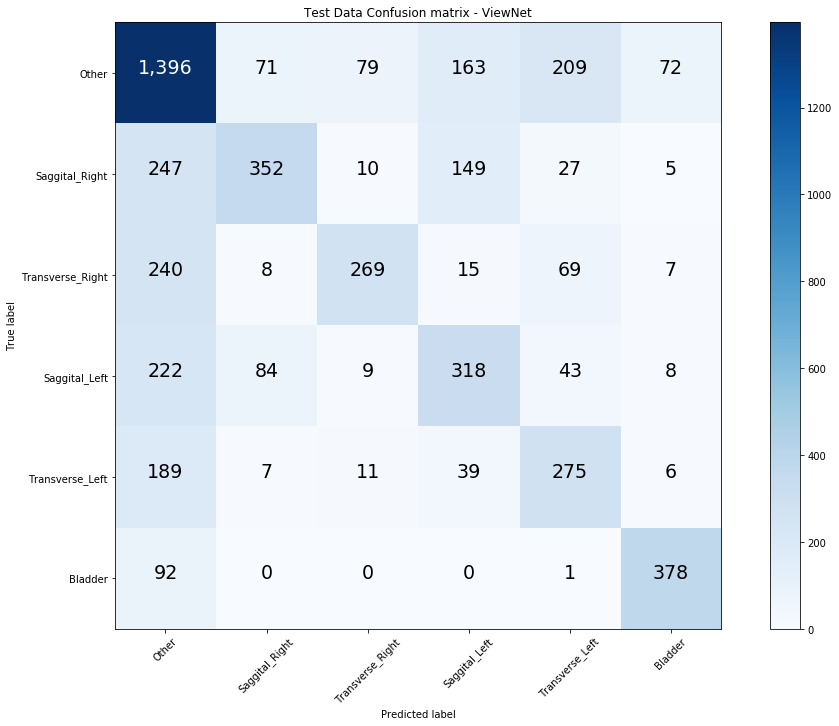

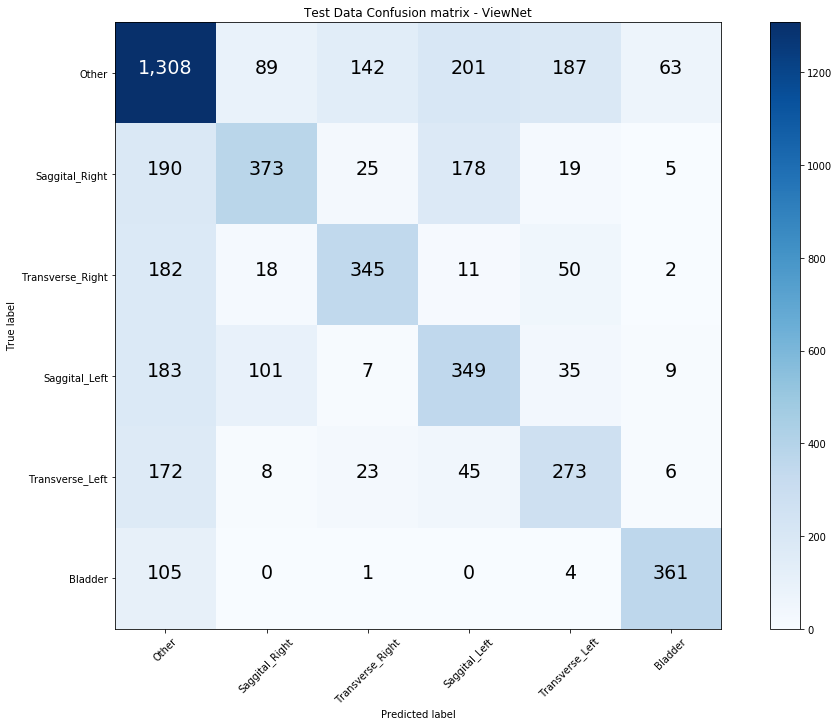

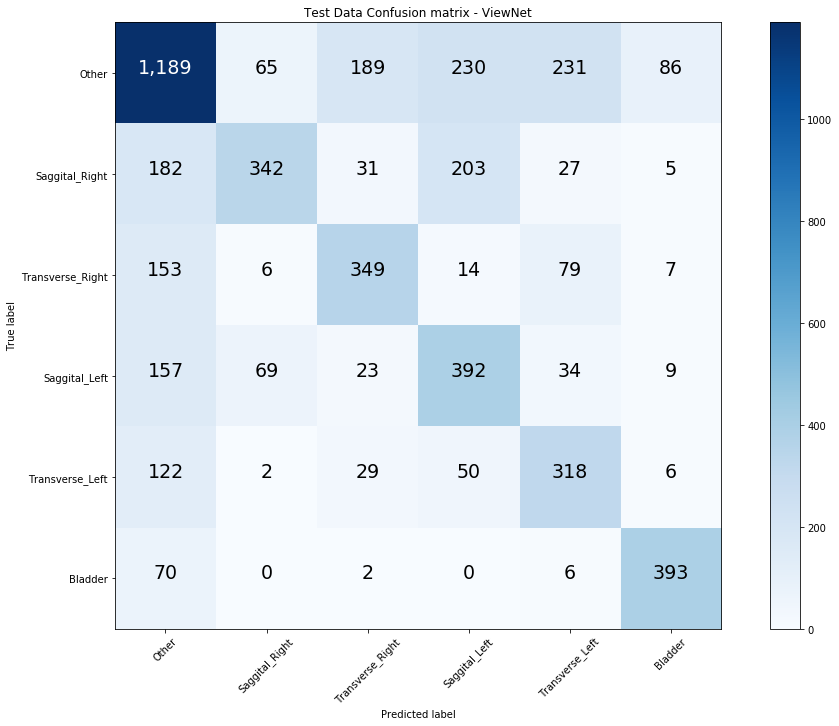

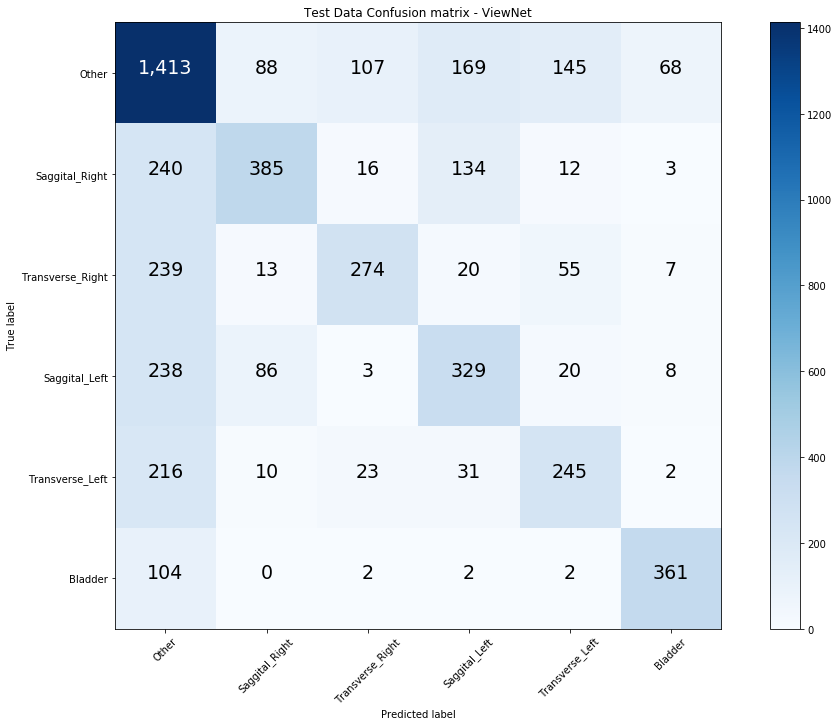

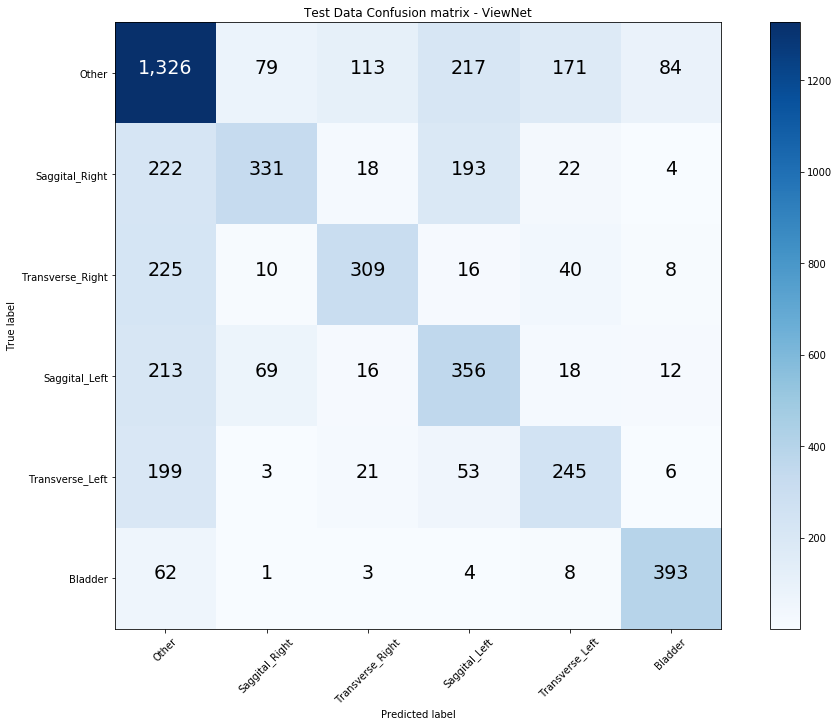

wandb: ERROR Error uploading "config.yaml": CommError, File /tmp/tmp55q20b53wandb/config.yaml size shrank from 12945 to 8192 while it was being uploaded.


In [13]:
repetitions = 1

conv1_filters = 8
conv2_filters = 16
conv3_filters = 32
linear1_size = 512

dropout = 0.25
lr = 0.0005
wd = 0.001
amsgrad = False

config_string = f"{conv1_filters}_{conv2_filters}_{conv3_filters}_{linear1_size}_{dropout}_{lr}_{wd}_{amsgrad}"
model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
run_configs = {'lr': lr, 'wd': wd, 'amsgrad': amsgrad,'dropout': dropout, 
              'conv1_filters': conv1_filters, 'conv2_filters': conv2_filters, 
              'conv3_filters': conv3_filters, 'linear1_size': linear1_size }

final_df = train5fold(run_configs, model_ft, lr, wd, amsgrad, repetitions)

# model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
# print(model_ft)
# num_parameters = sum(p.numel() for p in model_ft.parameters())
# print(num_parameters)

In [ ]:
final_df.head()